# evaluation 4

Evaluating the models that generalize. i.e trained on many celltypes, test on some new ones

In [1]:
#let's start with the generalizing model. The one where we included GM12878 should be easy

import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
# print(sys.path)
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import JointMaskingDecoder
from src.tasks.encoders import JointCNN
# from src.tasks.encoders import EnformerEncoder
from caduceus.configuration_caduceus import CaduceusConfig
import torch
import numpy as np
from src.dataloaders.datasets.general_dataset import GeneralDataset
import yaml
from omegaconf import OmegaConf
import os
import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm
import argparse
import itertools
import inspect
import zarr
from numcodecs import Blosc
from scipy.stats import spearmanr, pearsonr

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")
    

class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 data_idxs=None, #the actual value in the full self.dataset.data (so for GM12878 it's 12 or 69)
                 additional_idxs=None
                 ) -> None:
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        if self.cfg['train'].get('custom_metric', None) == 'ce_loss_mask_acc': #makes sure we never do softplus in the loss if it's a categorical model!
            self.skip_softplus=True
        else:
            self.skip_softplus=False
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            
            if data_idxs is not None:
                dataset_args['data_idxs'] = data_idxs #override the strings of files to whatever you want!
            if additional_idxs is not None:
                dataset_args['additional_idxs'] = additional_idxs
            
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = JointMaskingDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.encoder = JointCNN(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None, softplus=True, og=False):
        #now evaluate the model on one example
        if data is None:
            (seq,acc),(seq_unmask,acc_unmask) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
        else:
            x,y,seq_unmask,acc_unmask = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
        
        x,y = x.to(self.device), y.to(self.device)
        
        with torch.no_grad():
            x1 = self.encoder(x,y)
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1)
            seq,acc = x1

            if softplus and not self.skip_softplus:
                acc = torch.nn.functional.softplus(x1[1])
        
        return seq, acc, seq_unmask, acc_unmask
    
    def mask(self, start=None, stop=None, idx=None, data=None, run=True,
             mask_accessibility=False, mask_sequence=False,
             randomize_sequence=False, randomize_accessibility=False,
             start_acc=None, stop_acc=None
             ):
        '''given an index for the dataset, or just the data, it can mask the data that you want, then runs it through the model, lots of options like to mask accessibility or sequence etc.
        If you don't mask anything, then it's like seeing how confident the model is. But it can mask out regions and see that
        
        Args:
            start (int): the start index to mask, if None requires you don't randomize or mask anything
            stop (int): the end index to mask, if None requires you don't randomize or mask anything
            idx (int, optional): the index of the data in the dataset to use. If None, data must be provided. Defaults to None.
            data (tuple, optional): the data to use, in the form of (x,y,seq_unmask,acc_unmask). If None, idx must be provided. Defaults to None.
            run (bool, optional): whether to run the model on the masked data. If False, it will just return the masked data. Defaults to True.
            mask_accessibility (bool, optional): whether to mask the accessibility values. Defaults to False.
            mask_sequence (bool, optional): whether to mask the sequence values. Defaults to False.
            randomize_sequence (bool, optional): whether to randomize the sequence values instead of masking them. Defaults to False.
            randomize_accessibility (bool, optional): whether to randomize the accessibility values instead of masking them. Defaults to False.
            start_acc (int, optional): the start index to randomize the accessibility values. If None, defaults to start
            stop_acc (int, optional): the end index to randomize the accessibility values. If None, defaults to stop
            
        Returns:
            seq_out (torch.Tensor): the output sequence after running the model, if run is True.
            acc_out (torch.Tensor): the output accessibility after running the model, if run is True.
            seq_unmask_out (torch.Tensor): the original unmasked sequence, if run is True.
            acc_unmask_out (torch.Tensor): the original unmasked accessibility, if run is True.
            x (torch.Tensor): the input sequence after masking, if run is True.
            y (torch.Tensor): the input accessibility after masking, if run is True.
        '''
        if data is not None:
            (x,y,seq_unmask,acc_unmask) = data
        elif idx is not None:
            (x,y),(seq_unmask,acc_unmask) = self.dataset[idx]
        else:
            raise ValueError("Must provide either idx or data")
        
        #now mask the data
        seq = seq_unmask.clone().transpose(1,0) #now is N x length
        acc = acc_unmask.clone().transpose(1,0)
        acc[-1] = 0
        seq[-1] = 0 #zero out the mask so it runs unmasked
        
        if start_acc is None:
            start_acc = start
            stop_acc = stop
        
        if randomize_accessibility:
            random_start = np.random.randint(0, acc.shape[1] - (stop_acc-start_acc)-1) #doesn't include the end point
            acc[0,start:stop] = acc[0,random_start:random_start+(stop_acc-start_acc)]
        
        if mask_accessibility:
            acc[-1, start_acc:stop_acc] = 1 #tells the model it's masked
            acc[0, start_acc:stop_acc] = 0 #zero out the original accessibility values
            
        if randomize_sequence:
            random_indices = torch.randint(0, 4, size=(stop-start,))
            seq[:4,start:stop] = torch.nn.functional.one_hot(random_indices, num_classes=4).transpose(1,0)
            
        if mask_sequence:
            seq[-1,start:stop] = 1
            seq[:-1,start:stop] = 0 #zero out the original sequence values
        
        if run:
            x = seq.unsqueeze(0).to(self.device)
            y = acc.unsqueeze(0).to(self.device)
            data = (x,y,seq_unmask,acc_unmask)
            seq_out, acc_out, seq_unmask_out, acc_unmask_out = self(data=data)
        
            return seq_out, acc_out, seq_unmask_out, acc_unmask_out, x, y #it returns the values that were used as inputs, so yyou can see the modified inputs as well as th eoriginal data
        
        else:
            #just return the masked data
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
            return None, None, seq_unmask, acc_unmask, x, y

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-17/12-31-41-192495/checkpoints/last.ckpt'


In [2]:
evals = Evals(ckpt_path, dataset=None, split='test', device='cuda:3', load_data=False)

replacing cell type number with data indices
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [3]:
#so in this case we get the full dataset features! all the celltypes
len(evals.dataset)

5310

In [4]:
#that's not right
evals.dataset.sequences.shape

(1062, 4)

In [5]:
#why only 1062 sequences...
#OH! We're using my shorter sequences.bed file, this is fine!
#but if we only do one cell type
evals.dataset_args
# evals = Evals(ckpt_path, dataset=None, split='test', device='cuda:3', load_data=False, data_idxs=[0], additional_idxs=[0])

{'data_path': '/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/dnase_chunkchrom_processed.zarr',
 'length': 524288,
 'shift_sequences': 1000,
 'load_in': False,
 'rc_aug': False,
 'mlm': 0.25,
 'acc_mlm': 0.25,
 'acc_type': 'continuous',
 'acc_mask_size': 500,
 'weight_peaks': False,
 'data_idxs': '/data1/lesliec/sarthak/data/DK_zarr/idx_lists/nob_immune.json',
 'split': 'test',
 'evaluating': True}

In [6]:
evals = Evals(ckpt_path, dataset=None, split='test', device='cuda:3', load_data=False, data_idxs=[12])
len(evals.dataset)

replacing cell type number with data indices
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


1062

# Now actually evaluating

In [1]:
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-17/12-31-41-192495/checkpoints/last.ckpt' #for the generalizing model

#start with seeing how it generalizes to new regions
evals = Evals(ckpt_path, dataset=None, split='test', device='cuda:3', load_data=False)

replacing cell type number with data indices
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


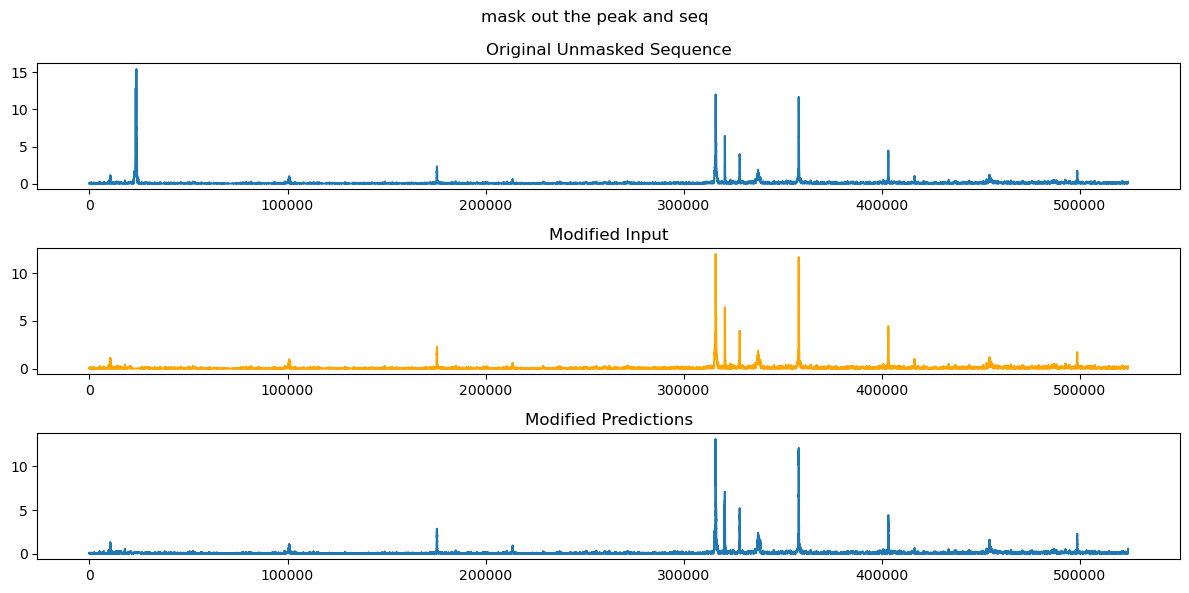

In [3]:
import matplotlib.pyplot as plt
(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[15] #get the original data
max_index = acc_unmask[:,0].argmax()

out = evals.mask(max_index-2000,max_index+2000, 15, mask_accessibility=True)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()

In [6]:
out[-1].shape

torch.Size([1, 2, 524288])

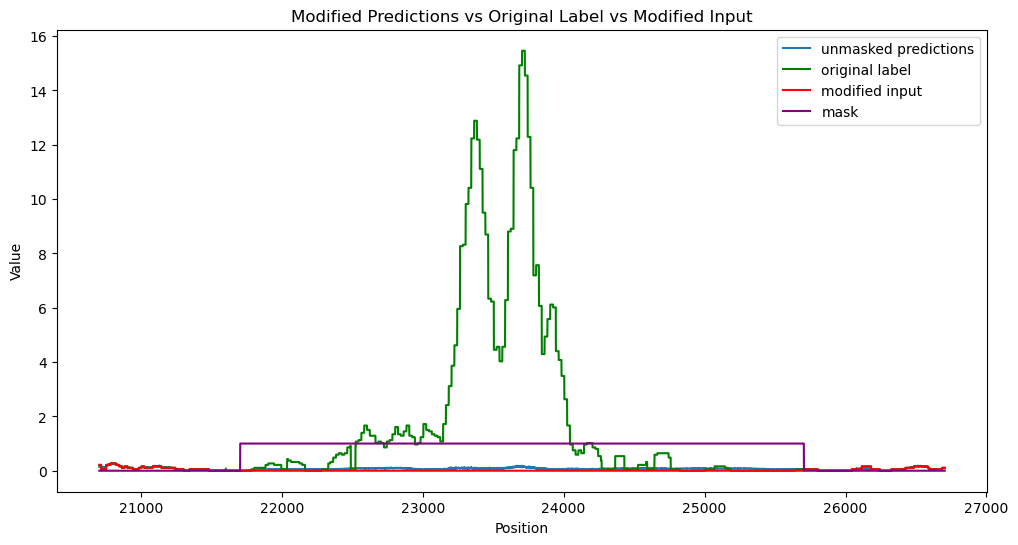

In [7]:
import numpy as np
start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

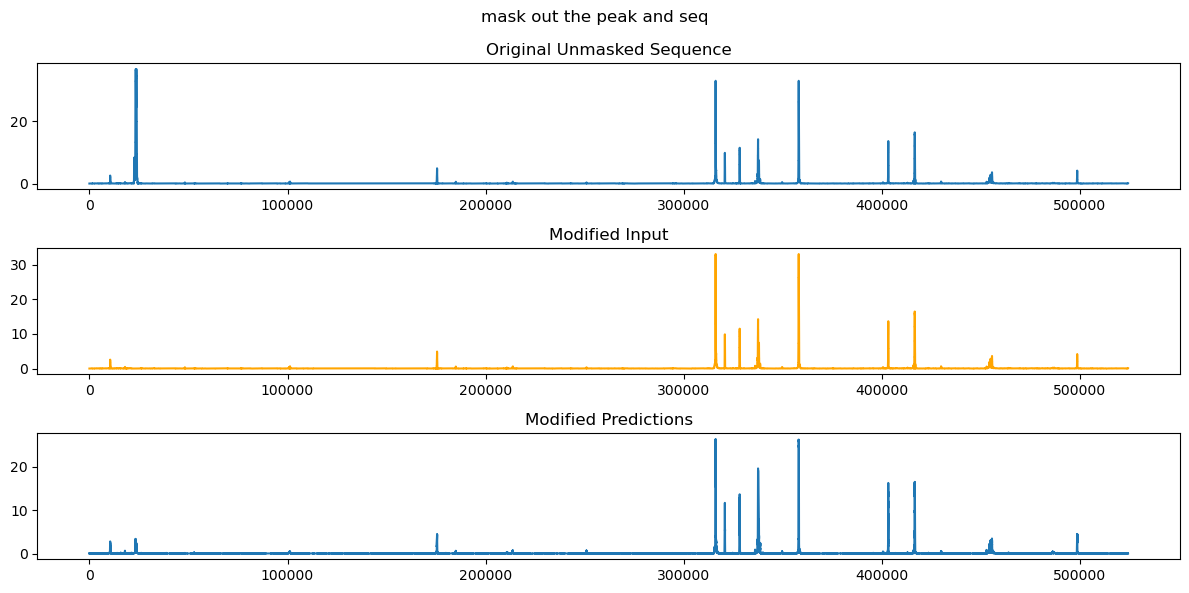

In [8]:
#let's look at the same example another cell type
idx = 15+evals.dataset.sequences.shape[0] #this is the index for the other cell type, same seq
(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[idx] #get the original data
max_index = acc_unmask[:,0].argmax()

out = evals.mask(max_index-2000,max_index+2000, idx, mask_accessibility=True)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()

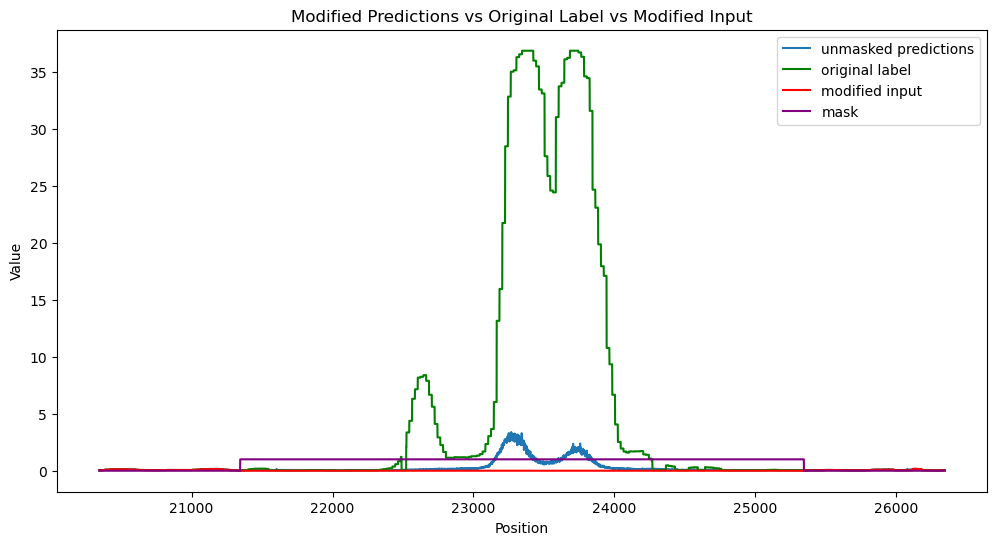

In [9]:
start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

In [3]:
#let's find a value that could be interesting, like to compare with the one that we did in GM12878
import pandas as pd
enformer_seqs = '/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed'
df = pd.read_csv(enformer_seqs, sep='\t', header=None)
df
# evals.dataset.expand_seqs

,0,1,2,3
0,chr18,928386,1059458,train
1,chr4,113630947,113762019,train
2,chr11,18427720,18558792,train
3,chr16,85805681,85936753,train
4,chr3,158386188,158517260,train
...,...,...,...,...
38166,chr19,33204702,33335774,test
38167,chr14,41861379,41992451,test
38168,chr19,30681544,30812616,test
38169,chr14,61473198,61604270,test


In [ ]:
list(df.iloc[15]) #this is what we want to check and compare with!

['chr19', 2552762, 2683834, 'train']

In [4]:
evals.dataset.expand_seqs(df.iloc[15][0], df.iloc[15][1], df.iloc[15][2])

1062

In [ ]:
#let's see the size of the dataset
len(evals.dataset) #expanded by 5, one for each celltype!!

5315

In [7]:
len(evals.dataset.sequences) #this is the size of the dataset, 5 times the original size

1063

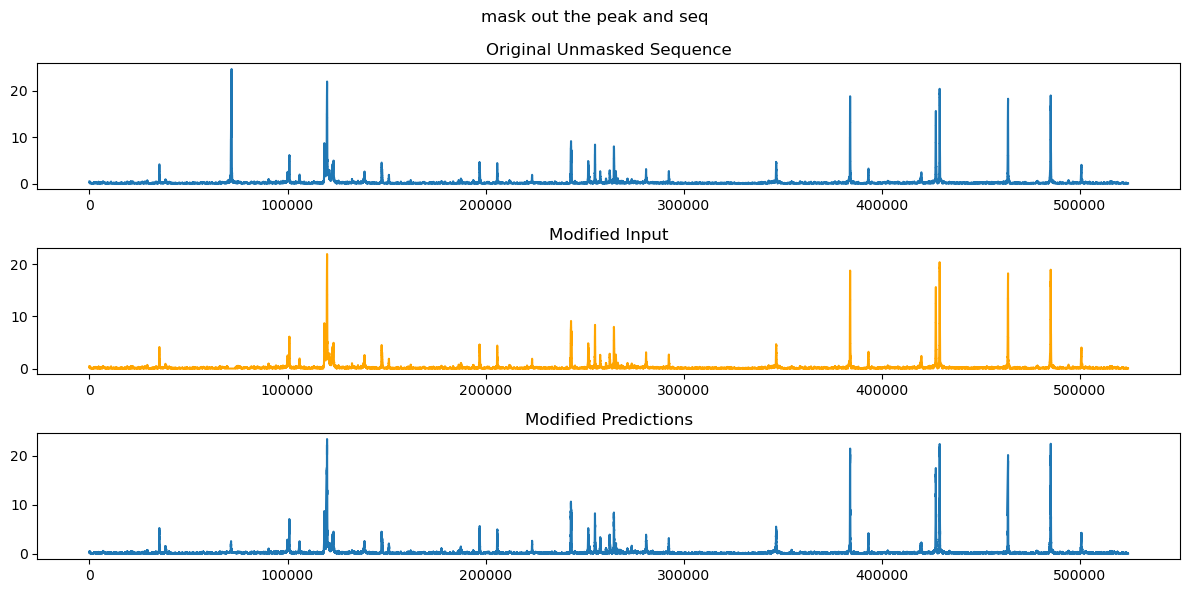

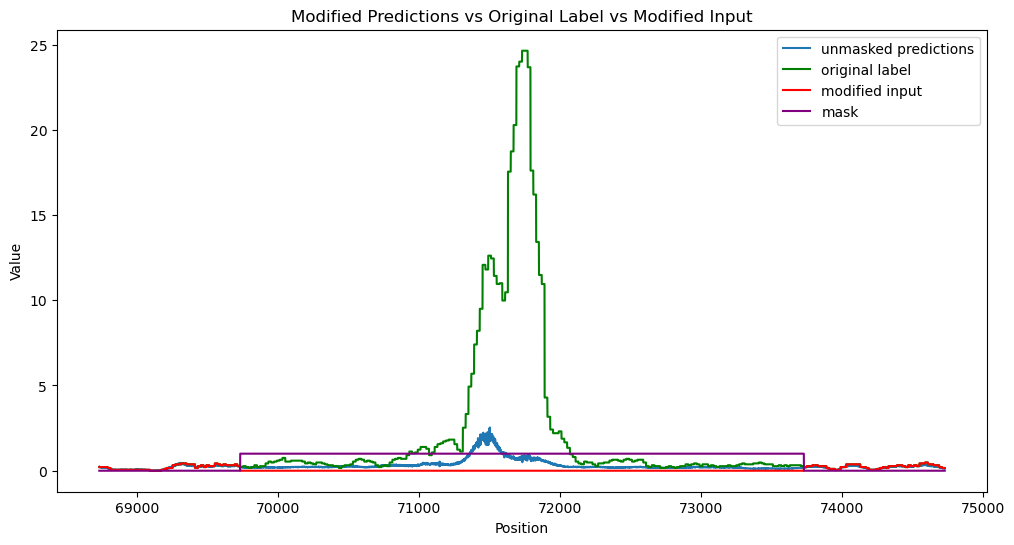

In [8]:
idx = 1062
(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[idx] #get the original data
max_index = acc_unmask[:,0].argmax()

out = evals.mask(max_index-2000,max_index+2000, idx, mask_accessibility=True)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()
plt.show()

start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()
plt.show()

# make this consistent

In [3]:
#I modified my function, let's see if it works so that we can replicate things much simpler!
#we'll try to get the good looking plot

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
evals = Evals(ckpt_path,device=3)
(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[15] #get the original data
max_index = acc_unmask[:,0].argmax()

print(max_index)

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
tensor(316025)


In [4]:
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-17/12-31-41-192495/checkpoints/last.ckpt' #for the generalizing model

#start with seeing how it generalizes to new regions
evals = Evals(ckpt_path, dataset=None, split='test', device='cuda:3', load_data=False)

replacing cell type number with data indices
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [6]:
import pandas as pd
enformer_seqs = '/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed'
df = pd.read_csv(enformer_seqs, sep='\t', header=None)
evals.dataset.expand_seqs(df.iloc[15][0], df.iloc[15][1], df.iloc[15][2])

1062

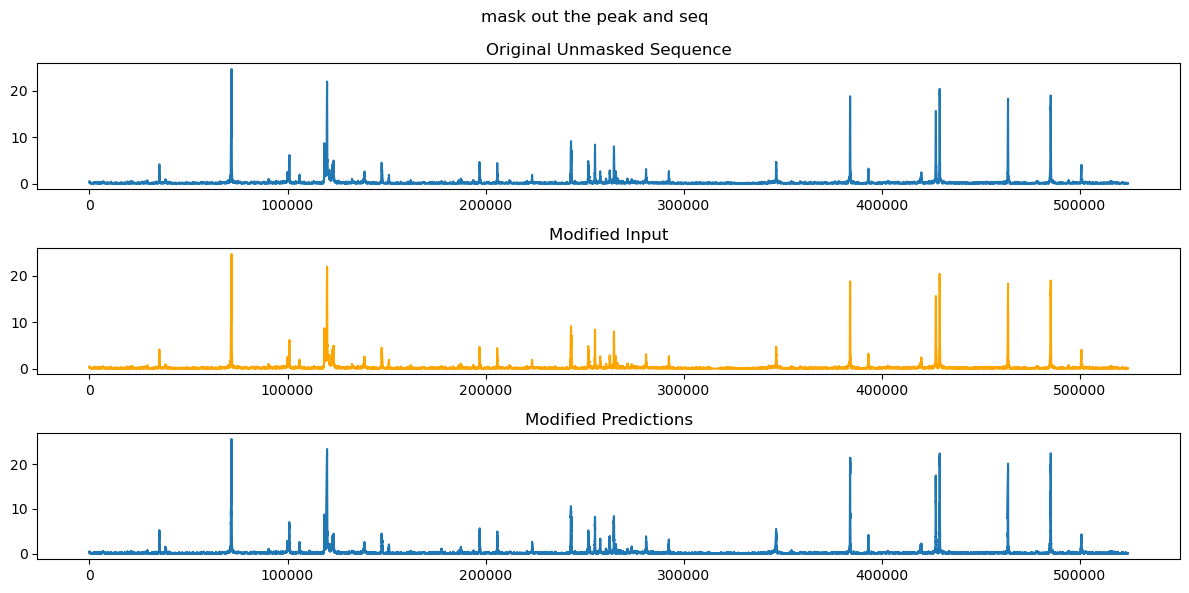

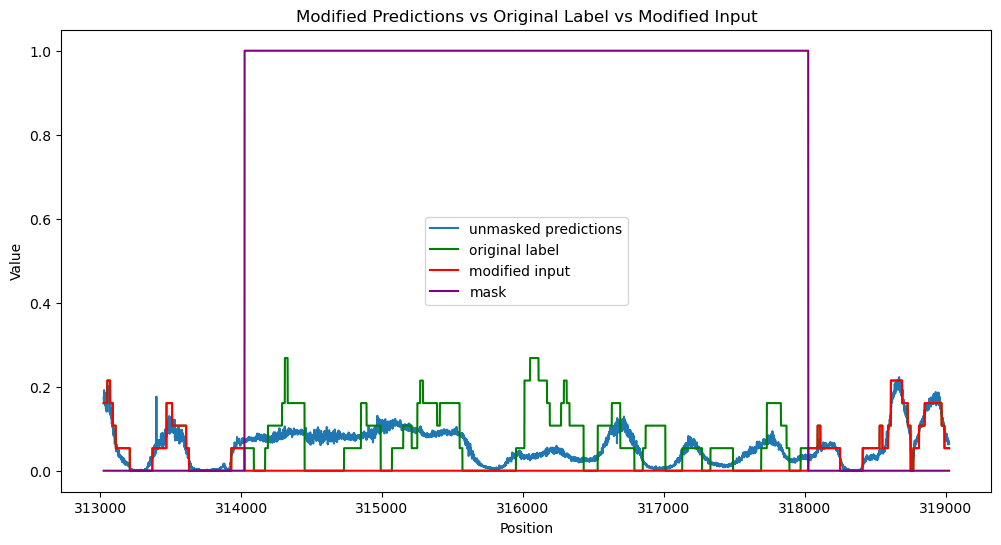

In [7]:
idx = 1062
# (seq,acc),(seq_unmask,acc_unmask) = evals.dataset[idx] #get the original data
# max_index = acc_unmask[:,0].argmax()

out = evals.mask(max_index-2000,max_index+2000, idx, mask_accessibility=True)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()
plt.show()

start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()
plt.show()

# use full trained model so can truly compare

In [ ]:
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

split = 'test'

enformer_seqs = '/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed'
df = pd.read_csv(enformer_seqs, sep='\t', header=None)
df = df[df[3] == split].reset_index(drop=True)

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-17/12-29-49-150674/checkpoints/last.ckpt' #for the generalizing model

#start with seeing how it generalizes to new regions
evals = Evals(ckpt_path, dataset=None, split=split, device='cuda:3', load_data=False)
len(evals.dataset)

replacing cell type number with data indices
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


7434

In [ ]:
1062*7 #yeah matches!

7434

In [2]:
#now for a given index, let's see if we can match sequence to what we saw in examples when just GM12878
evals.dataset.data_idxs #it's the 12 so the 7th cell type

array([457, 177, 354, 120, 522, 392,  12])

In [3]:
idx = 100
evals.dataset.expand_seqs(df.iloc[100][0], df.iloc[100][1], df.iloc[100][2])

1062

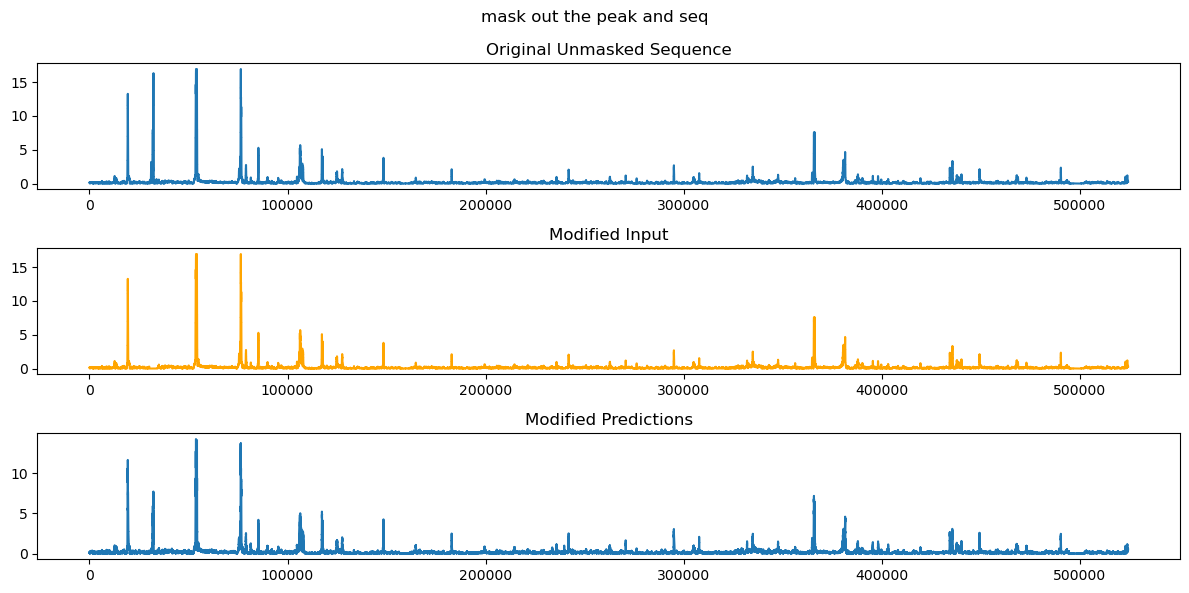

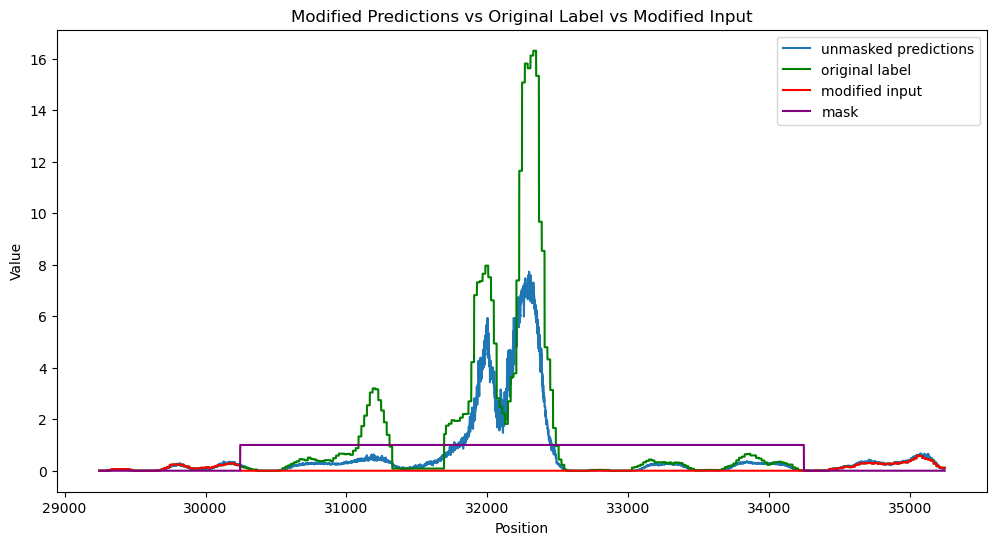

In [5]:
tempidx = 1062+len(evals.dataset.sequences)*6 #this is the index for the other cell type, same seq
# (seq,acc),(seq_unmask,acc_unmask) = evals.dataset[tempidx] #get the original data
# max_index = acc_unmask[:,0].argmax()
# print(max_index)
max_index=32246 #from evaluation_joint.ipynb where we do this example

out = evals.mask(max_index-2000,max_index+2000, tempidx, mask_accessibility=True)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()
plt.show()

start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()
plt.show()

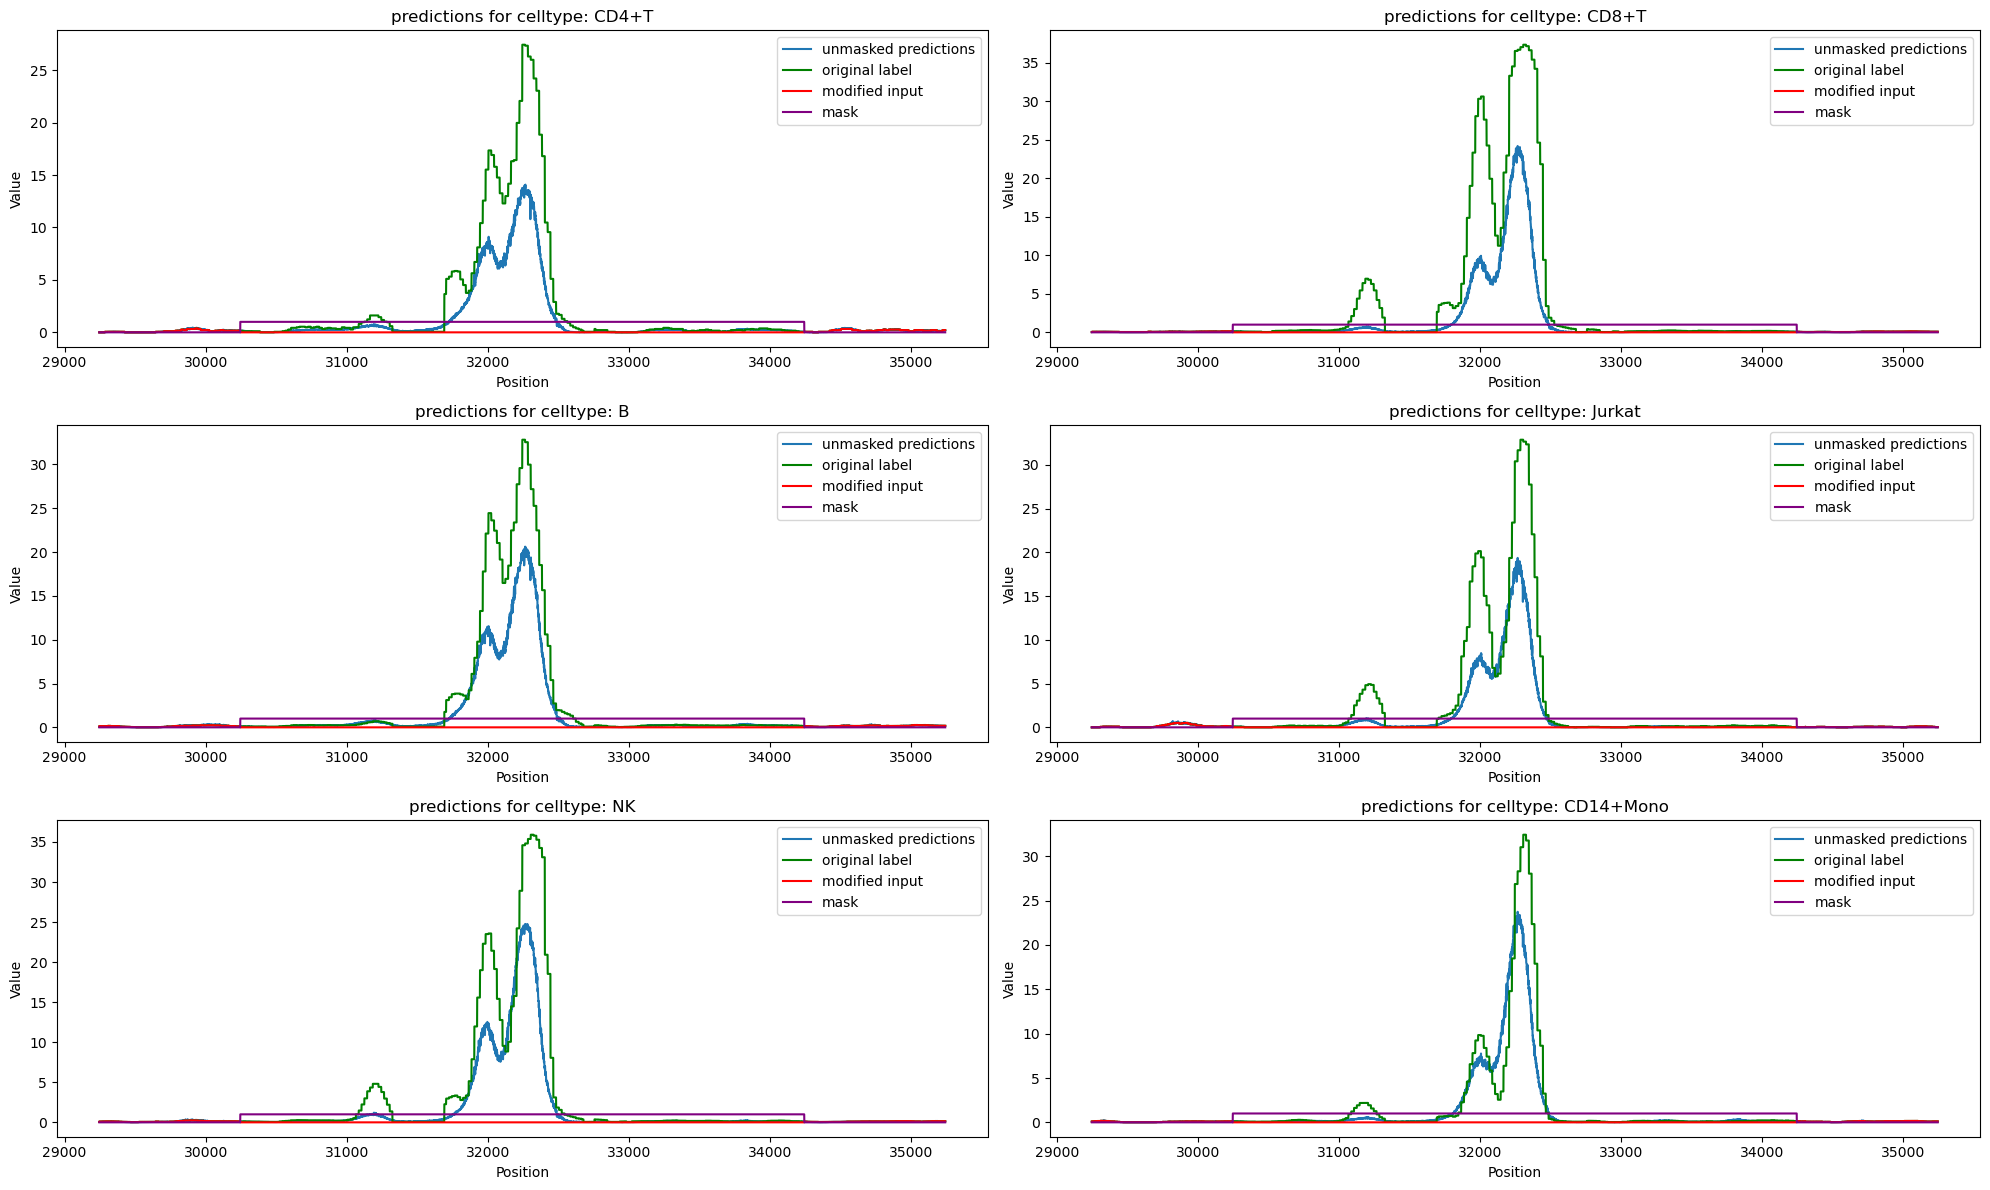

In [7]:
#now let's compare all the celltypes!
#let's get celltype names
celltype_names = ['CD4+T', 'CD8+T', 'B', 'Jurkat', 'NK', 'CD14+Mono', 'GM12878']

#now loop through and make it a subplot
fig, axs = plt.subplots(3, 2, figsize=(20, 12))
axs = axs.flatten()
for i in range(6):
    tempidx = 1062 + len(evals.dataset.sequences) * i
    out = evals.mask(max_index-2000, max_index+2000,
                     tempidx, mask_accessibility=True)

    start = max_index - 3000
    end   = max_index + 3000
    x_vals = np.arange(start, end)

    y_vals           = out[1][0, start:end, 0].cpu().numpy()
    y_vals_original  = out[3][:, 0].cpu().numpy()[start:end]
    y_vals_input     = out[5][0, 0, start:end].cpu().numpy()
    mask             = out[-1][0, 1, start:end].cpu().numpy()

    ax = axs[i]
    ax.plot(x_vals, y_vals,          label='unmasked predictions')
    ax.plot(x_vals, y_vals_original, label='original label', color='green')
    ax.plot(x_vals, y_vals_input,    label='modified input', color='red')
    ax.plot(x_vals, mask,            label='mask',           color='purple')

    ax.set_xlabel('Position')
    ax.set_ylabel('Value')
    ax.set_title(f'predictions for celltype: {celltype_names[i]}')
    ax.legend()

fig.tight_layout()
plt.show()

In [8]:
#this was maybe in the train set? Let's see
df.iloc[100]

0       chr19
1    54280007
2    54411079
3        test
Name: 100, dtype: object

# let's redo this so we can make sure we can replicate it

In [ ]:
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

split = 'test'

enformer_seqs = '/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed'
df = pd.read_csv(enformer_seqs, sep='\t', header=None)
df = df[df[3] == split].reset_index(drop=True)

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-17/12-29-49-150674/checkpoints/last.ckpt' #for the generalizing model

#start with seeing how it generalizes to new regions
evals = Evals(ckpt_path, dataset=None, split=split, device='cuda:3', load_data=False)

replacing cell type number with data indices
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [3]:
max_index = 32246 #from evaluation_joint.ipynb where we do this example

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


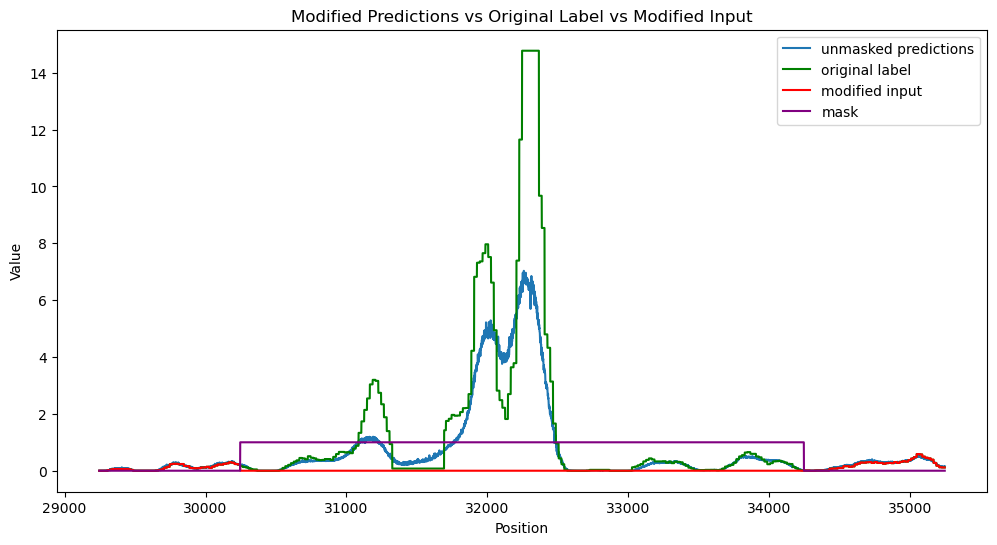

In [4]:
#and to ensure we can replicate it
ckpt_path_og = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'
evals_og = Evals(ckpt_path_og, dataset=None, split='test', device='cuda:3', load_data=False, sequences_bed_file=enformer_seqs)

out = evals_og.mask(max_index-2000, max_index+2000,100, mask_accessibility=True)
start = max_index - 3000
end   = max_index + 3000
x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()
plt.show()

In [5]:
#perfect replication!! Now let's look at an example from the test set of this og model
evals_og.dataset.sequences

,0,1,2,3
0,chr10,37555537,37686609,test
1,chr14,87048845,87179917,test
2,chrX,136527085,136658157,test
3,chr11,34042349,34173421,test
4,chr19,10352757,10483829,test
...,...,...,...,...
1932,chr19,33204702,33335774,test
1933,chr14,41861379,41992451,test
1934,chr19,30681544,30812616,test
1935,chr14,61473198,61604270,test


In [6]:
#find one that shares the test set chroms
evals.dataset.sequences

,0,1,2,3
0,chr4,0,524288,test
1,chr4,262144,786432,test
2,chr4,524288,1048576,test
3,chr4,786432,1310720,test
4,chr4,1048576,1572864,test
...,...,...,...,...
1057,chr14,105381888,105906176,test
1058,chr14,105644032,106168320,test
1059,chr14,105906176,106430464,test
1060,chr14,106168320,106692608,test


In [ ]:
#find where og is chr4 or chr14 in column 0
evals_og.dataset.sequences[evals_og.dataset.sequences[0].isin(['chr4','chr14'])] #almost half overlap? crazy!

,0,1,2,3
1,chr14,87048845,87179917,test
5,chr14,23281761,23412833,test
6,chr14,66863581,66994653,test
9,chr14,87163534,87294606,test
10,chr14,97944300,98075372,test
...,...,...,...,...
1923,chr14,30965924,31096996,test
1927,chr14,82805352,82936424,test
1929,chr14,44040470,44171542,test
1933,chr14,41861379,41992451,test


In [9]:
#now let's go through these sequences
idxs = evals_og.dataset.sequences[evals_og.dataset.sequences[0].isin(['chr4','chr14'])][0].index
idxs

Index([   1,    5,    6,    9,   10,   15,   18,   20,   26,   29,
       ...
       1906, 1907, 1913, 1914, 1922, 1923, 1927, 1929, 1933, 1935],
      dtype='int64', length=754)

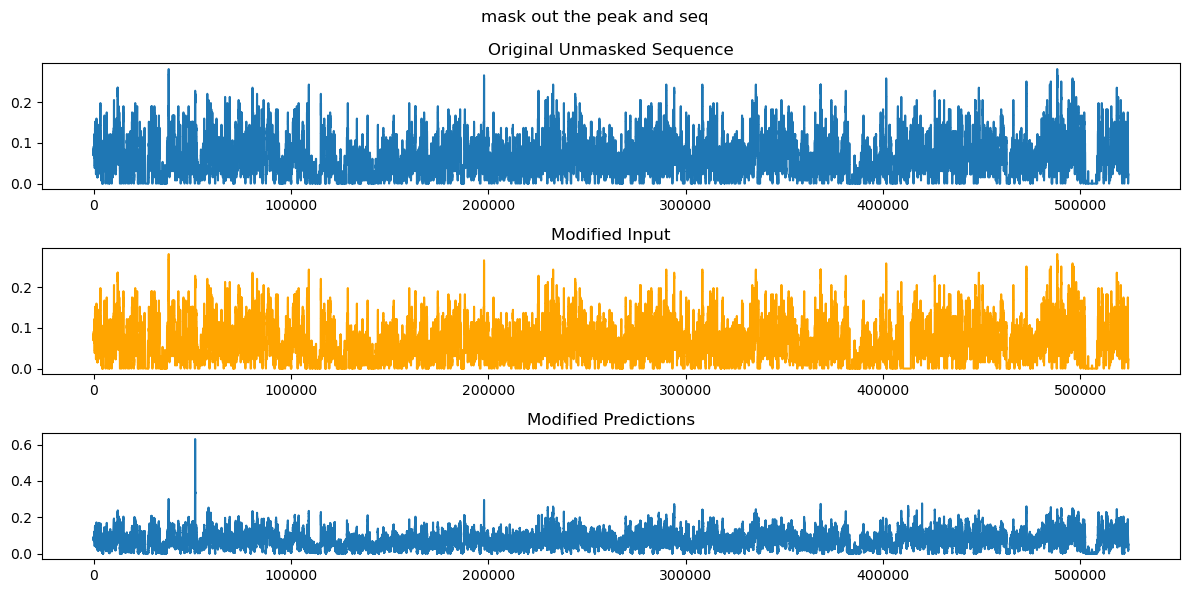

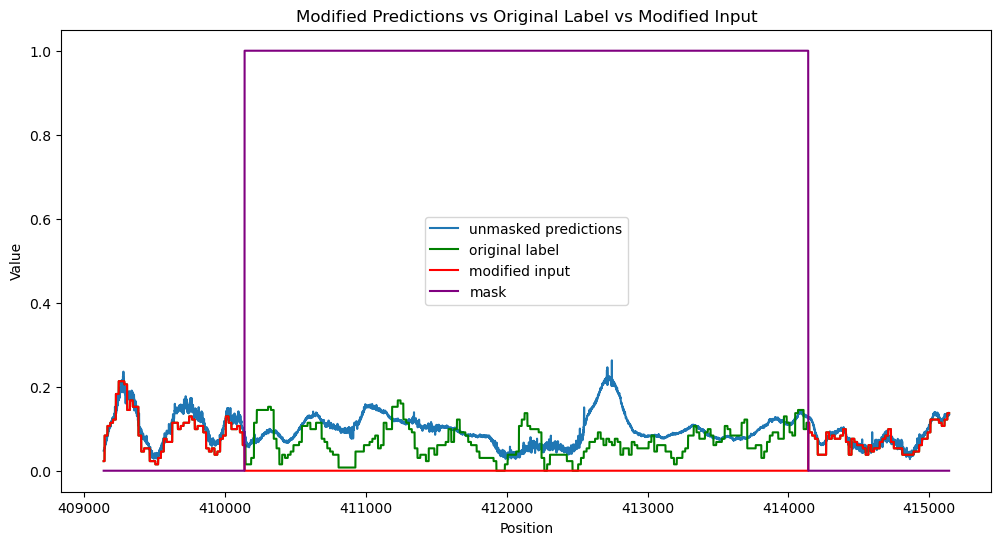

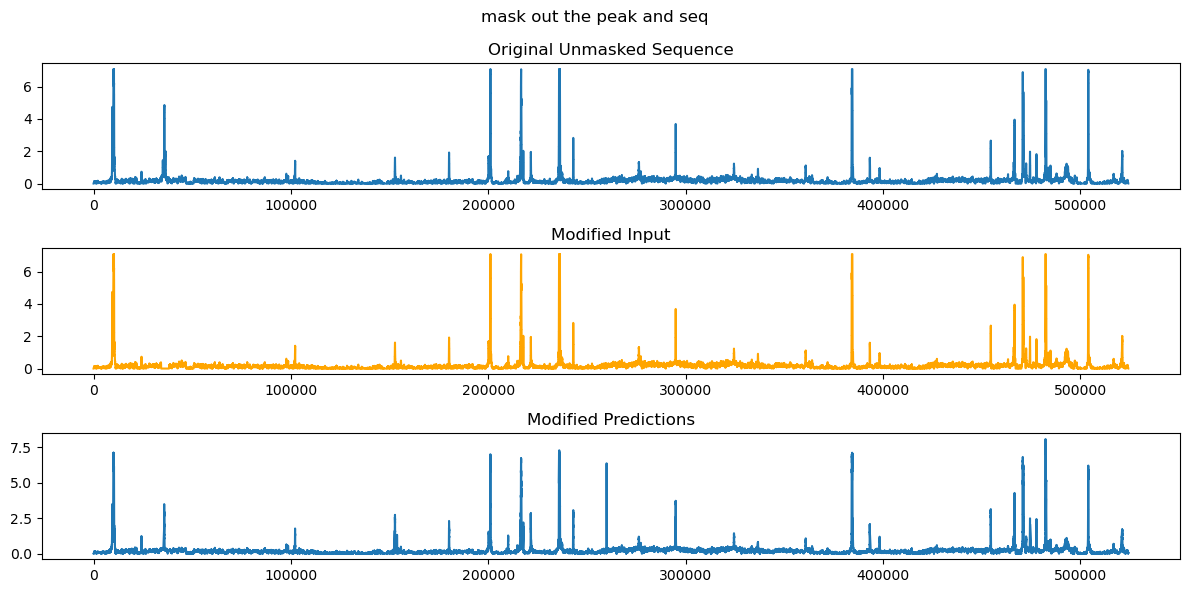

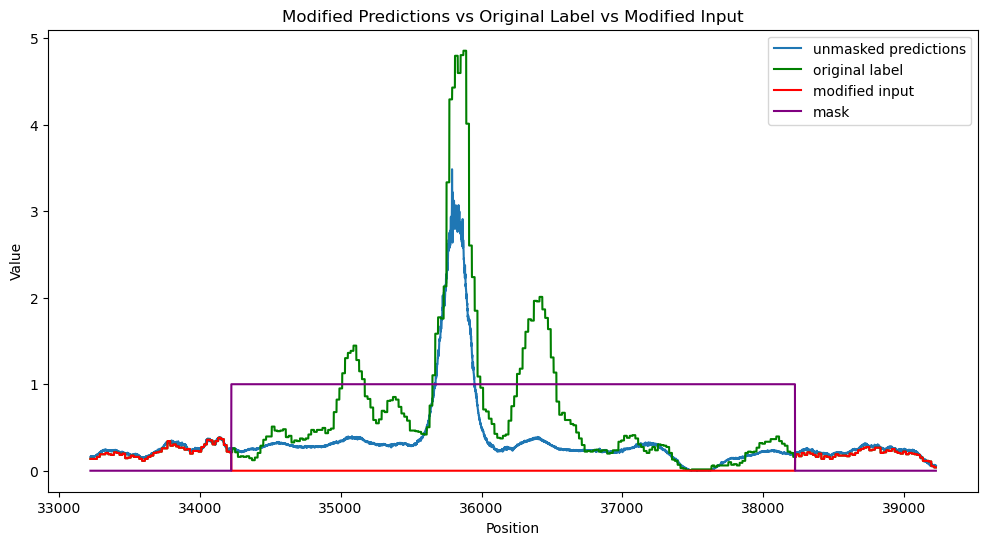

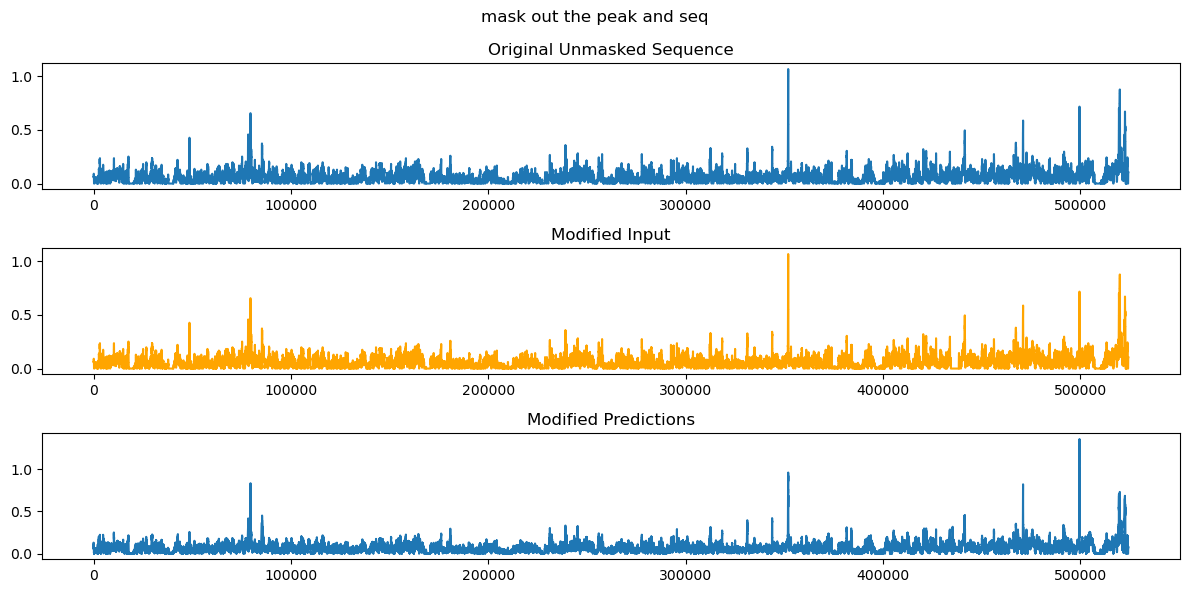

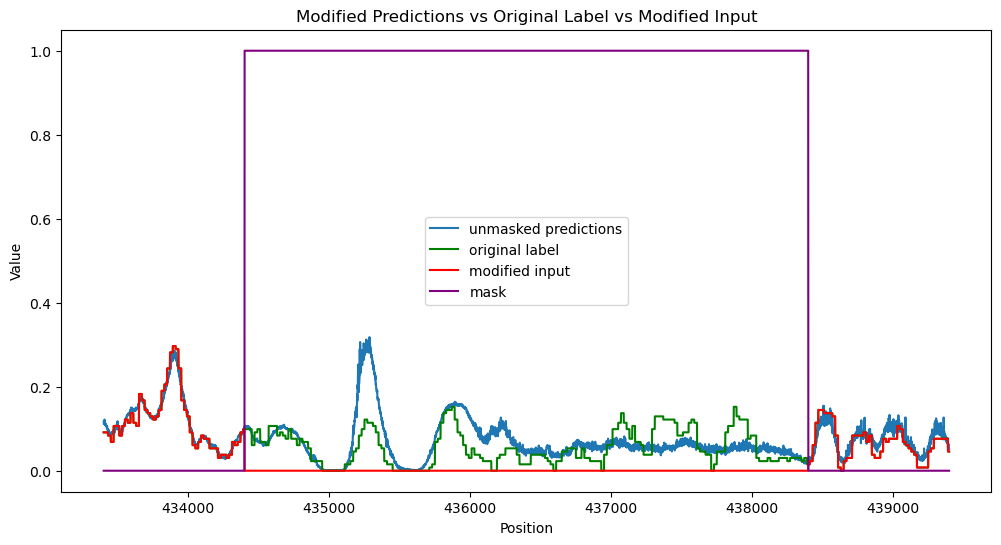

KeyboardInterrupt: 

In [16]:
for idx in idxs:
    (seq,acc),(seq_unmask,acc_unmask) = evals.dataset[idx] #get the original data
    max_index = acc_unmask[:,0].argmax()
    # print(max_index)
    # max_index=32246 #from evaluation_joint.ipynb where we do this example

    out = evals_og.mask(max_index-2000,max_index+2000, idx, mask_accessibility=True)

    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
    plt.title('Original Unmasked Sequence')

    plt.subplot(3, 1, 2)
    plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
    plt.title('Modified Input')

    plt.subplot(3, 1, 3)
    plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
    plt.title('Modified Predictions')

    plt.suptitle('mask out the peak and seq')


    plt.tight_layout()
    plt.show()

    start = max_index - 3000
    end = max_index + 3000

    x_vals = np.arange(start,end)
    y_vals = out[1][0, start:end, 0].cpu().numpy()

    plt.subplots(figsize=(12, 6))

    plt.plot(x_vals, y_vals, label='unmasked predictions')

    #and get the actual values
    y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
    plt.plot(x_vals, y_vals_original, label='original label', color='green')

    #and plot the input to the model
    y_vals_input = out[5][0,0, start:end].cpu().numpy()
    plt.plot(x_vals, y_vals_input, label='modified input', color='red')

    mask = out[-1][0,1, start:end].cpu().numpy()
    plt.plot(x_vals, mask, label='mask', color='purple')

    plt.xlabel('Position')
    plt.ylabel('Value')
    plt.title('Modified Predictions vs Original Label vs Modified Input')
    plt.legend()
    plt.show()

tensor(36225)


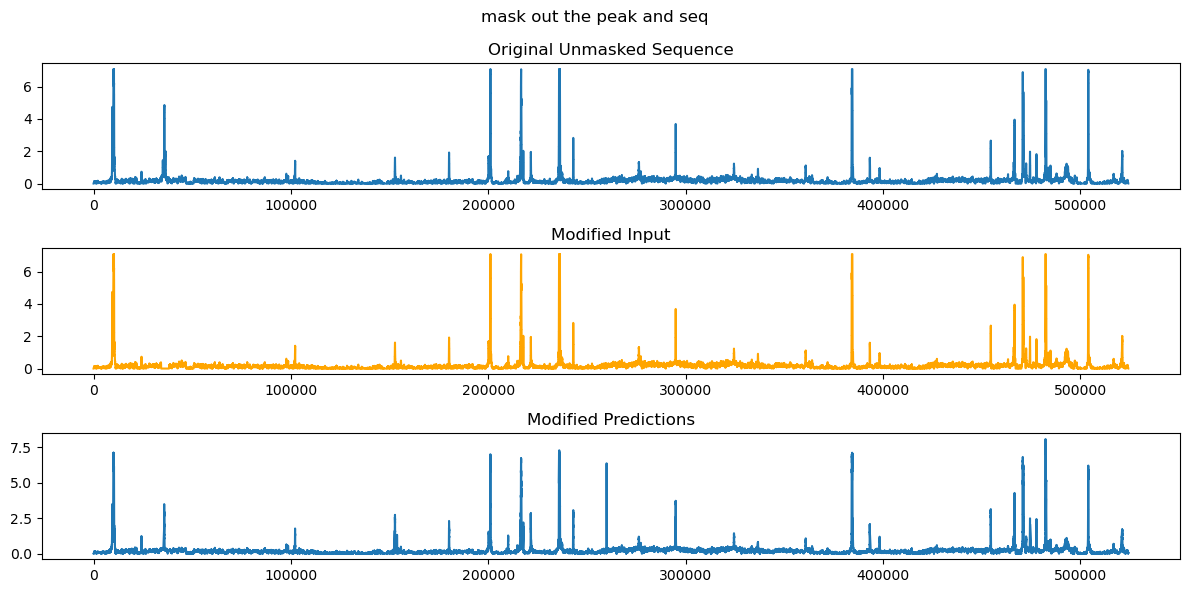

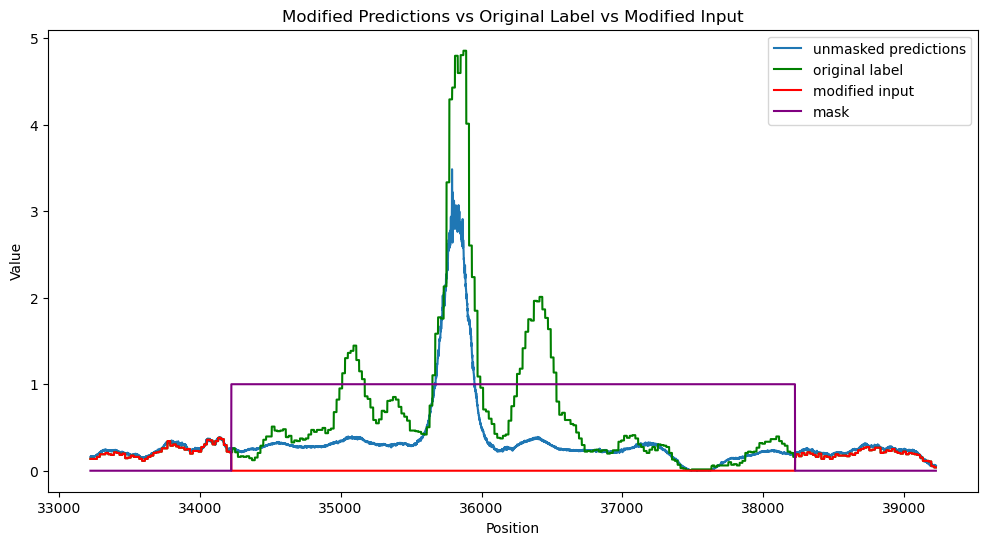

In [18]:
#retest with idxs[1]
idx = idxs[1]
(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[idx] #get the original data
max_index = acc_unmask[:,0].argmax()
print(max_index)
# max_index=32246 #from evaluation_joint.ipynb where we do this example

out = evals_og.mask(max_index-2000,max_index+2000, idx, mask_accessibility=True)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()
plt.show()

start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()
plt.show()

In [12]:
#these first 2 examples are kinda good lol!
#now let's see the input
#first we have to append to sequences
idx1 = idxs[0]
print(evals.dataset.expand_seqs(df.iloc[idx1][0], df.iloc[idx1][1], df.iloc[idx1][2]))
idx2 = idxs[1]
print(evals.dataset.expand_seqs(df.iloc[idx2][0], df.iloc[idx2][1], df.iloc[idx2][2]))

1062
1063


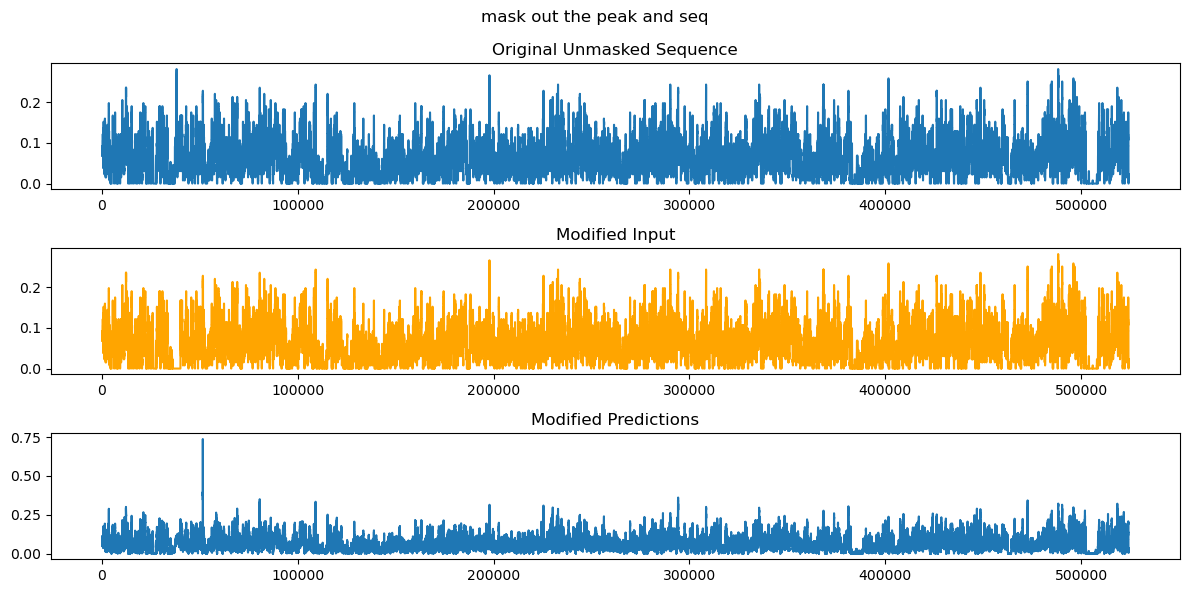

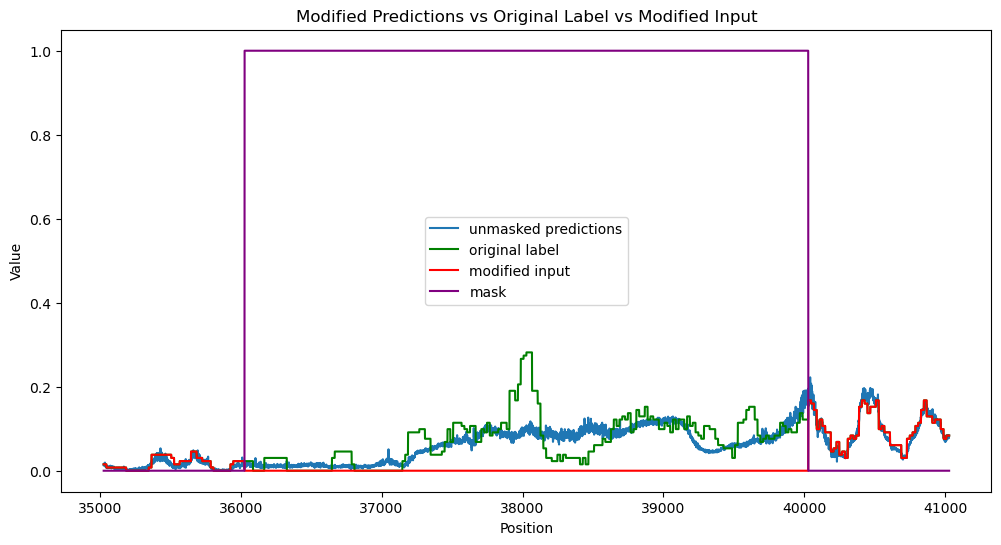

In [14]:
tempidx = 1062+len(evals.dataset.sequences)*6 #this is the index for the other cell type, same seq
(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[tempidx] #get the original data
max_index = acc_unmask[:,0].argmax()
# print(max_index)
# max_index=32246 #from evaluation_joint.ipynb where we do this example

out = evals.mask(max_index-2000,max_index+2000, tempidx, mask_accessibility=True)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()
plt.show()

start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()
plt.show()

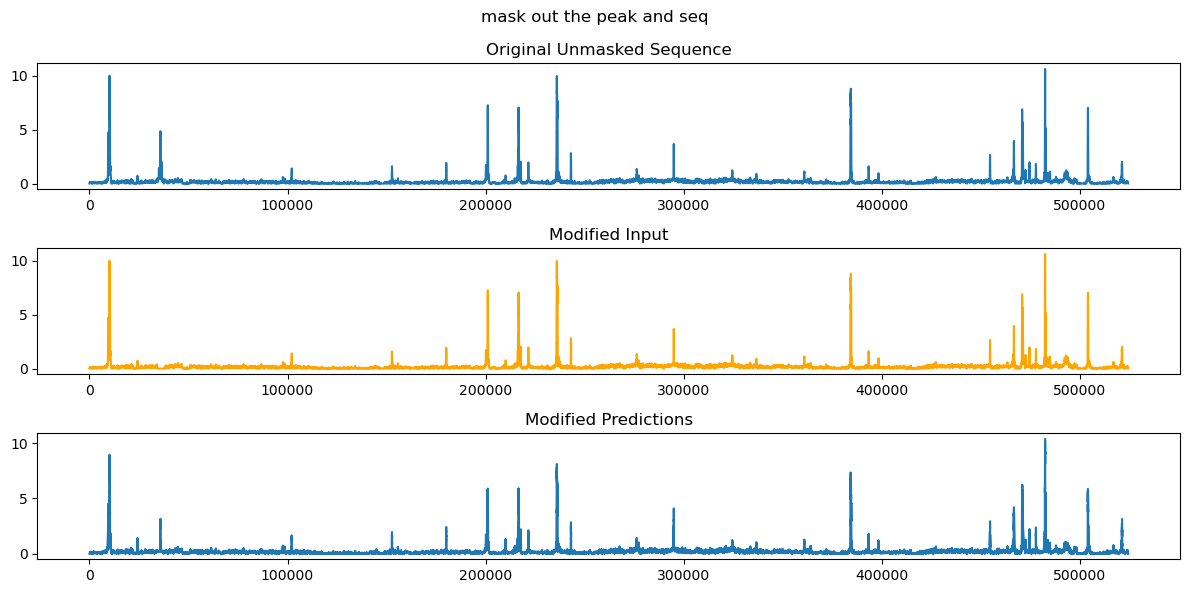

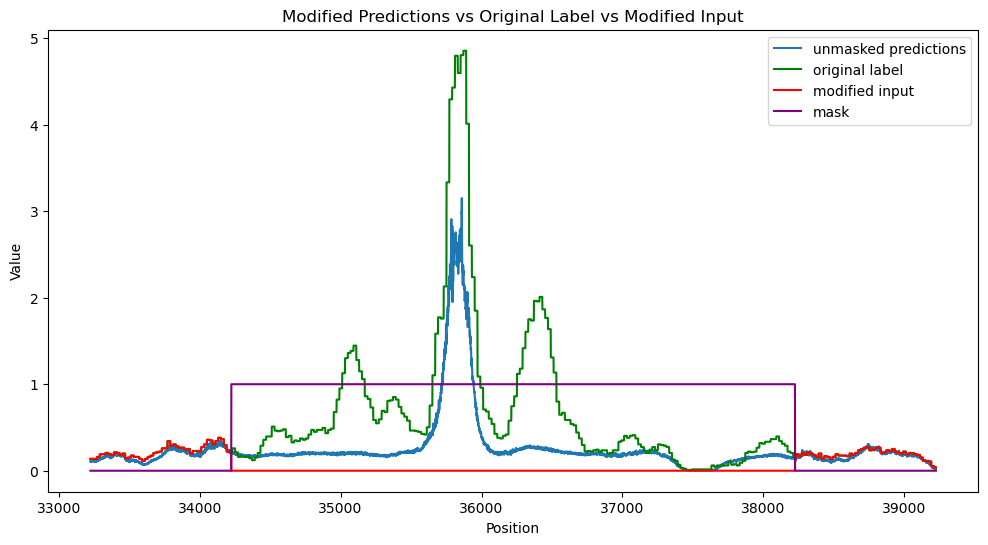

In [ ]:
#looks as we expect, but we really care about the second one!
tempidx = 1063+len(evals.dataset.sequences)*6 #this is the index for the other cell type, same seq
# (seq,acc),(seq_unmask,acc_unmask) = evals.dataset[tempidx] #get the original data
# max_index = acc_unmask[:,0].argmax()
max_index = 36225
# print(max_index)
# max_index=32246 #from evaluation_joint.ipynb where we do this example

out = evals.mask(max_index-2000,max_index+2000, tempidx, mask_accessibility=True)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()
plt.show()

start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()
plt.show()

#still looks really good!!

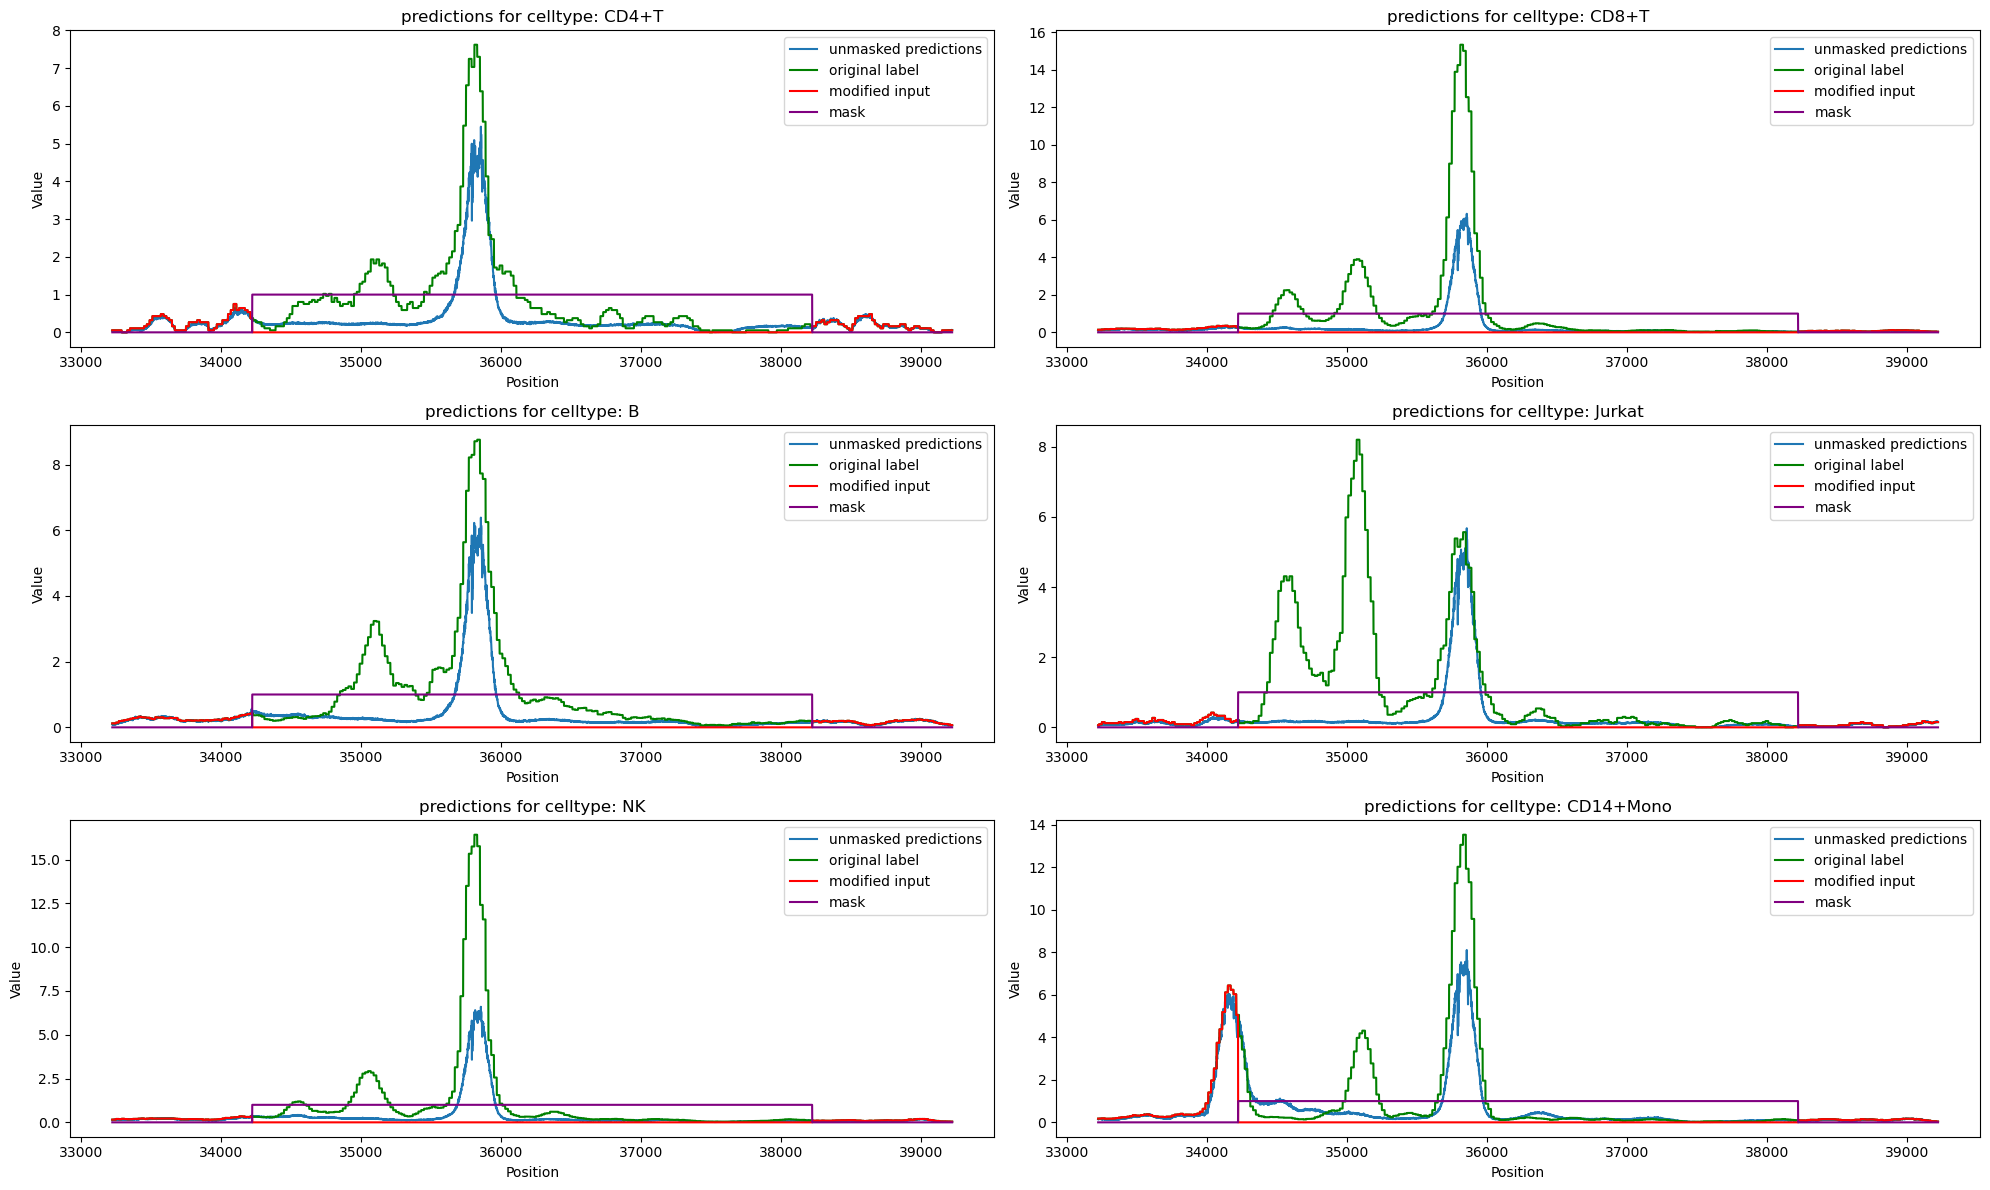

In [20]:
celltype_names = ['CD4+T', 'CD8+T', 'B', 'Jurkat', 'NK', 'CD14+Mono', 'GM12878']

#now loop through and make it a subplot
fig, axs = plt.subplots(3, 2, figsize=(20, 12))
axs = axs.flatten()
for i in range(6):
    tempidx = 1063 + len(evals.dataset.sequences) * i
    out = evals.mask(max_index-2000, max_index+2000,
                     tempidx, mask_accessibility=True)

    start = max_index - 3000
    end   = max_index + 3000
    x_vals = np.arange(start, end)

    y_vals           = out[1][0, start:end, 0].cpu().numpy()
    y_vals_original  = out[3][:, 0].cpu().numpy()[start:end]
    y_vals_input     = out[5][0, 0, start:end].cpu().numpy()
    mask             = out[-1][0, 1, start:end].cpu().numpy()

    ax = axs[i]
    ax.plot(x_vals, y_vals,          label='unmasked predictions')
    ax.plot(x_vals, y_vals_original, label='original label', color='green')
    ax.plot(x_vals, y_vals_input,    label='modified input', color='red')
    ax.plot(x_vals, mask,            label='mask',           color='purple')

    ax.set_xlabel('Position')
    ax.set_ylabel('Value')
    ax.set_title(f'predictions for celltype: {celltype_names[i]}')
    ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
#can absolutely look at more examples and make it functional, but let's just see how it generalizes now

# how well it can generalize

Will use the two examples we did above

In [21]:
#so first load in model

import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

split = 'test'

enformer_seqs = '/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed'
df = pd.read_csv(enformer_seqs, sep='\t', header=None)
df = df[df[3] == split].reset_index(drop=True)

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-17/12-29-49-150674/checkpoints/last.ckpt' #for the generalizing model

#start with seeing how it generalizes to new regions
evals = Evals(ckpt_path, dataset=None, split=split, device='cuda:3', load_data=False)

#now load it in for GM12878
evals_gm = Evals(ckpt_path, dataset=None, split='test', device='cuda:3', load_data=False, data_idxs=[12])

replacing cell type number with data indices
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
replacing cell type number with data indices
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


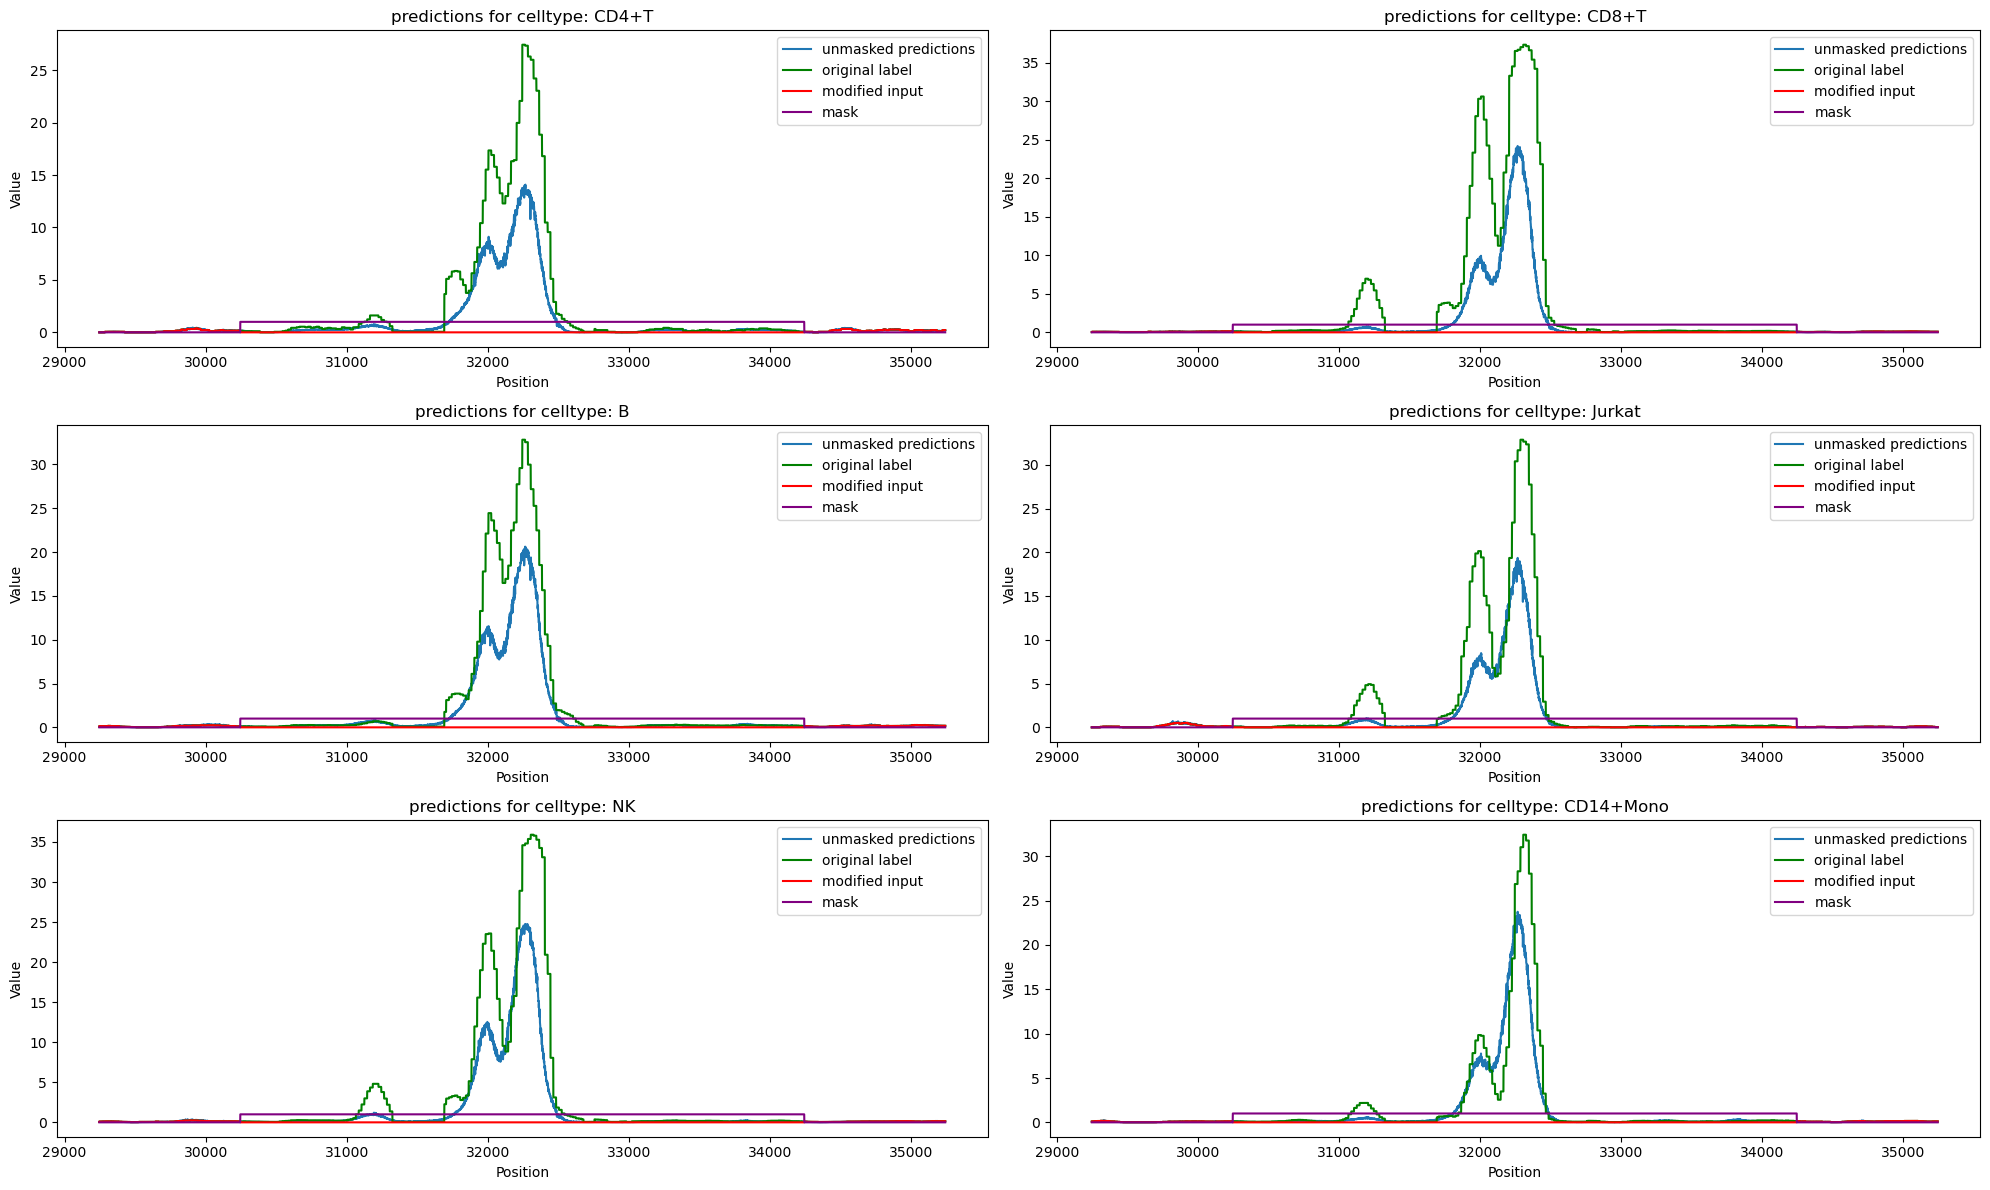

In [23]:
evals.dataset.expand_seqs(df.iloc[100][0], df.iloc[100][1], df.iloc[100][2])

celltype_names = ['CD4+T', 'CD8+T', 'B', 'Jurkat', 'NK', 'CD14+Mono', 'GM12878']
max_index=32246
#now loop through and make it a subplot
fig, axs = plt.subplots(3, 2, figsize=(20, 12))
axs = axs.flatten()
for i in range(6):
    tempidx = 1062 + len(evals.dataset.sequences) * i
    out = evals.mask(max_index-2000, max_index+2000,
                     tempidx, mask_accessibility=True)

    start = max_index - 3000
    end   = max_index + 3000
    x_vals = np.arange(start, end)

    y_vals           = out[1][0, start:end, 0].cpu().numpy()
    y_vals_original  = out[3][:, 0].cpu().numpy()[start:end]
    y_vals_input     = out[5][0, 0, start:end].cpu().numpy()
    mask             = out[-1][0, 1, start:end].cpu().numpy()

    ax = axs[i]
    ax.plot(x_vals, y_vals,          label='unmasked predictions')
    ax.plot(x_vals, y_vals_original, label='original label', color='green')
    ax.plot(x_vals, y_vals_input,    label='modified input', color='red')
    ax.plot(x_vals, mask,            label='mask',           color='purple')

    ax.set_xlabel('Position')
    ax.set_ylabel('Value')
    ax.set_title(f'predictions for celltype: {celltype_names[i]}')
    ax.legend()
    
fig.tight_layout()
plt.show()

In [25]:
#now test on GM12878
evals_gm.dataset.expand_seqs(df.iloc[100][0], df.iloc[100][1], df.iloc[100][2])
tempidx = 1062 #this is the index for the seq, this dataset only one cell type!

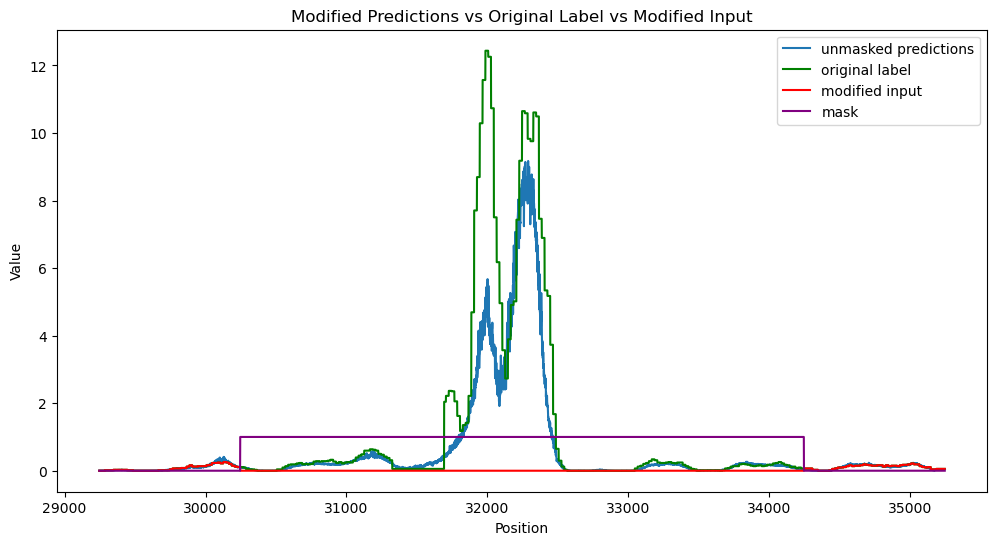

In [26]:
out = evals_gm.mask(max_index-2000, max_index+2000,
                     tempidx, mask_accessibility=True)
start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()
plt.show()

In [ ]:
len(evals_gm.dataset) #huh, why does the above plot look different than before. The first masked peak is taller than before...

1063

In [29]:
evals_gm.dataset.sequences.iloc[-1]

0       chr19
1    54280007
2    54411079
3        test
Name: 1062, dtype: object

In [30]:
#let's make sure it's the same
evals_gm.dataset.data['chr19'].shape

(674, 58617616)

In [31]:
start = 54280007
end = 54411079
length = end - start
if length < 524288:
    start = start - (524288 - length) // 2
    end = end + (524288 - length) // 2
print(start, end, end-start)

54083399 54607687 524288


In [32]:
vals = evals_gm.dataset.data['chr19'][12, start:end]

In [33]:
vals.shape

(524288,)

In [34]:
out[3][:,0]

tensor([0.0676, 0.0676, 0.0676,  ..., 0.0946, 0.0541, 0.0541])

In [35]:
vals

array([0.1522, 0.1522, 0.1522, ..., 0.3123, 0.2664, 0.2664], dtype=float16)

In [36]:
#yeah it differs, let's see what's up?
evals_gm.dataset.data_idxs

array([12])

In [ ]:
#so this is 12 indeed... AHH! We had a small bug where getting cell type 0 instead

# rerun

In [1]:
#so first load in model

import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

split = 'test'

enformer_seqs = '/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed'
df = pd.read_csv(enformer_seqs, sep='\t', header=None)
df = df[df[3] == split].reset_index(drop=True)

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-17/12-29-49-150674/checkpoints/last.ckpt' #for the generalizing model

#start with seeing how it generalizes to new regions
evals = Evals(ckpt_path, dataset=None, split=split, device='cuda:3', load_data=False)

#now load it in for GM12878
evals_gm = Evals(ckpt_path, dataset=None, split='test', device='cuda:3', load_data=False, data_idxs=[12])

replacing cell type number with data indices
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
replacing cell type number with data indices
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


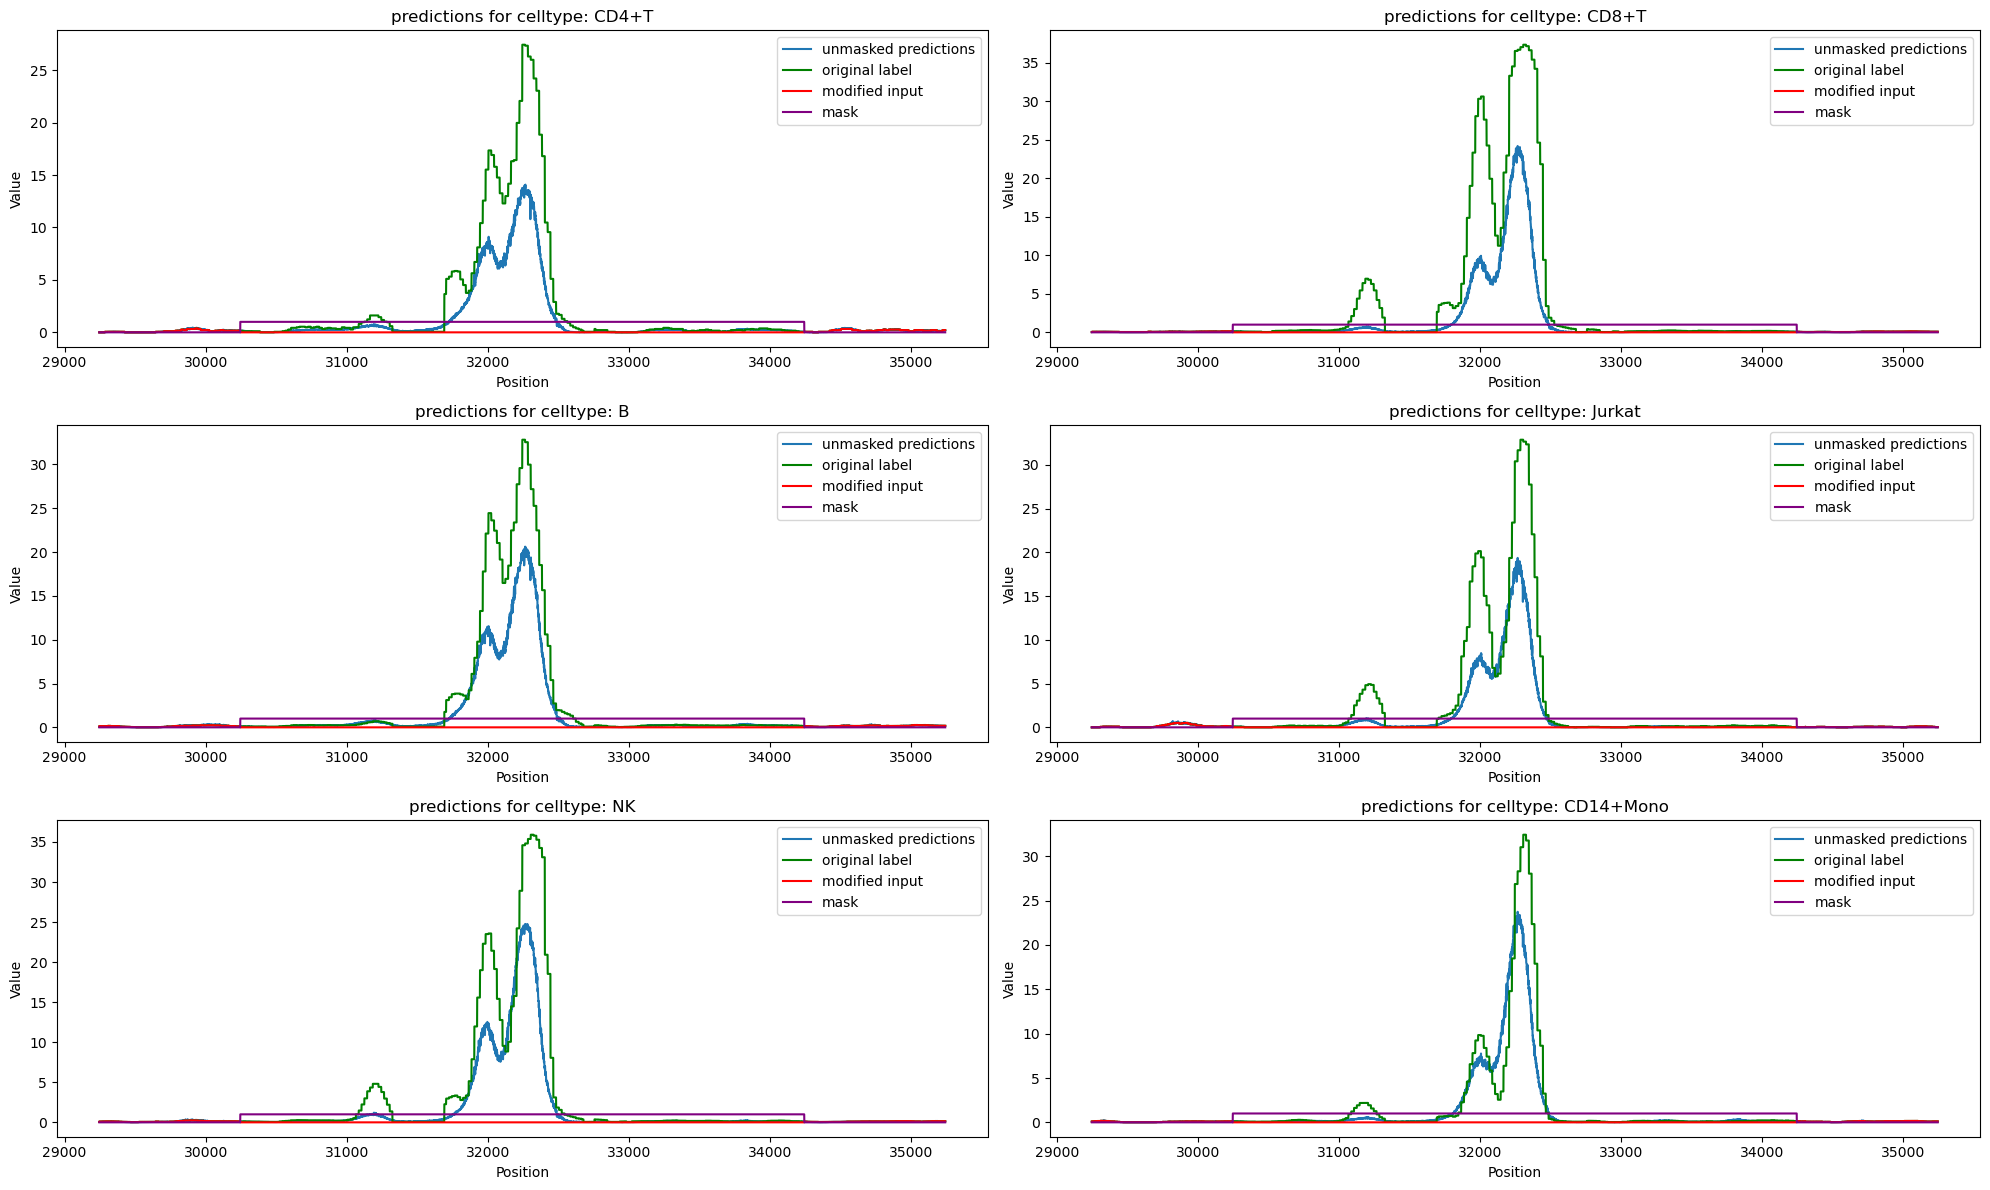

In [2]:
evals.dataset.expand_seqs(df.iloc[100][0], df.iloc[100][1], df.iloc[100][2])

celltype_names = ['CD4+T', 'CD8+T', 'B', 'Jurkat', 'NK', 'CD14+Mono', 'GM12878']
max_index=32246
#now loop through and make it a subplot
fig, axs = plt.subplots(3, 2, figsize=(20, 12))
axs = axs.flatten()
for i in range(6):
    tempidx = 1062 + len(evals.dataset.sequences) * i
    out = evals.mask(max_index-2000, max_index+2000,
                     tempidx, mask_accessibility=True)

    start = max_index - 3000
    end   = max_index + 3000
    x_vals = np.arange(start, end)

    y_vals           = out[1][0, start:end, 0].cpu().numpy()
    y_vals_original  = out[3][:, 0].cpu().numpy()[start:end]
    y_vals_input     = out[5][0, 0, start:end].cpu().numpy()
    mask             = out[-1][0, 1, start:end].cpu().numpy()

    ax = axs[i]
    ax.plot(x_vals, y_vals,          label='unmasked predictions')
    ax.plot(x_vals, y_vals_original, label='original label', color='green')
    ax.plot(x_vals, y_vals_input,    label='modified input', color='red')
    ax.plot(x_vals, mask,            label='mask',           color='purple')

    ax.set_xlabel('Position')
    ax.set_ylabel('Value')
    ax.set_title(f'predictions for celltype: {celltype_names[i]}')
    ax.legend()
    
fig.tight_layout()
plt.show()

In [3]:
#now test on GM12878
evals_gm.dataset.expand_seqs(df.iloc[100][0], df.iloc[100][1], df.iloc[100][2])
tempidx = 1062 #this is the index for the seq, this dataset only one cell type!

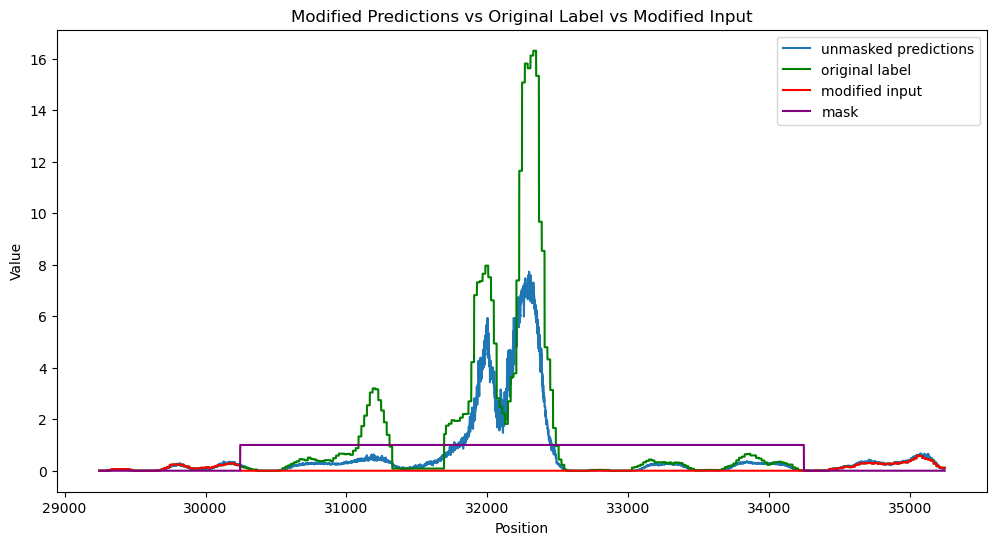

In [4]:
out = evals_gm.mask(max_index-2000, max_index+2000,
                     tempidx, mask_accessibility=True)
start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()
plt.show()

In [ ]:
#this looks too good. Because all of this is the generalizing model!!!!! Let's redo but use the actual model
#but this shows mine absolutely works. Accidentally gave it same input, sow e know it's the same input!!
#shouldn't have been able to plot B cells, it isn't there!!
#this is good tho since it means we can use this same trick to just get the one cell type!!

replacing cell type number with data indices


JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous
replacing cell type number with data indices
JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


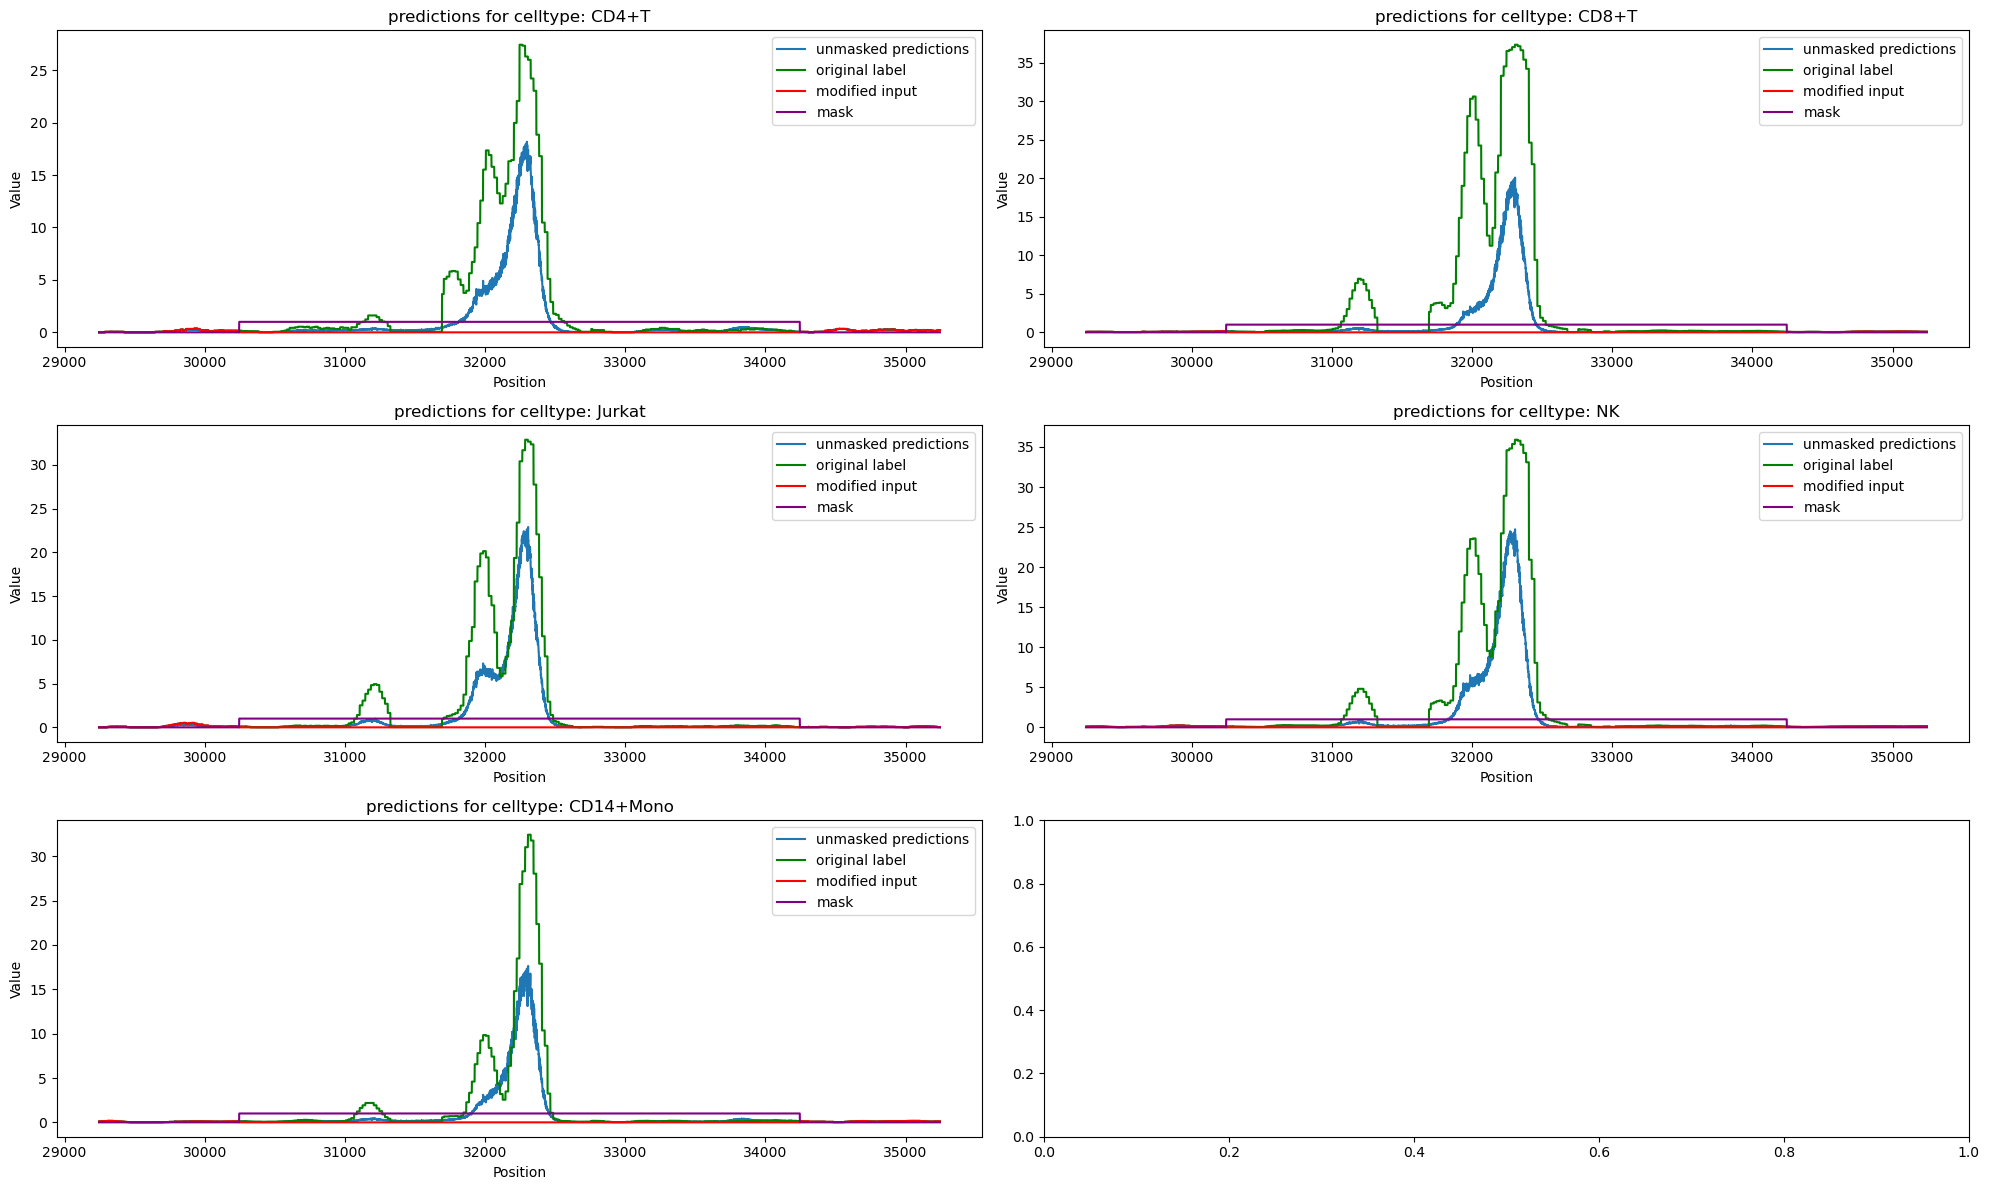

In [6]:
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

split = 'test'

enformer_seqs = '/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed'
df = pd.read_csv(enformer_seqs, sep='\t', header=None)
df = df[df[3] == split].reset_index(drop=True)

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-17/12-31-41-192495/checkpoints/last.ckpt' #for the generalizing model

#start with seeing how it generalizes to new regions
evals = Evals(ckpt_path, dataset=None, split=split, device='cuda:3', load_data=False)

#now load it in for GM12878
evals_gm = Evals(ckpt_path, dataset=None, split='test', device='cuda:3', load_data=False, data_idxs=[12])

evals.dataset.expand_seqs(df.iloc[100][0], df.iloc[100][1], df.iloc[100][2])

celltype_names = ['CD4+T', 'CD8+T', 'Jurkat', 'NK', 'CD14+Mono']
max_index=32246
#now loop through and make it a subplot
fig, axs = plt.subplots(3, 2, figsize=(20, 12))
axs = axs.flatten()
for i in range(5):
    tempidx = 1062 + len(evals.dataset.sequences) * i
    out = evals.mask(max_index-2000, max_index+2000,
                     tempidx, mask_accessibility=True)

    start = max_index - 3000
    end   = max_index + 3000
    x_vals = np.arange(start, end)

    y_vals           = out[1][0, start:end, 0].cpu().numpy()
    y_vals_original  = out[3][:, 0].cpu().numpy()[start:end]
    y_vals_input     = out[5][0, 0, start:end].cpu().numpy()
    mask             = out[-1][0, 1, start:end].cpu().numpy()

    ax = axs[i]
    ax.plot(x_vals, y_vals,          label='unmasked predictions')
    ax.plot(x_vals, y_vals_original, label='original label', color='green')
    ax.plot(x_vals, y_vals_input,    label='modified input', color='red')
    ax.plot(x_vals, mask,            label='mask',           color='purple')

    ax.set_xlabel('Position')
    ax.set_ylabel('Value')
    ax.set_title(f'predictions for celltype: {celltype_names[i]}')
    ax.legend()
    
fig.tight_layout()
plt.show()

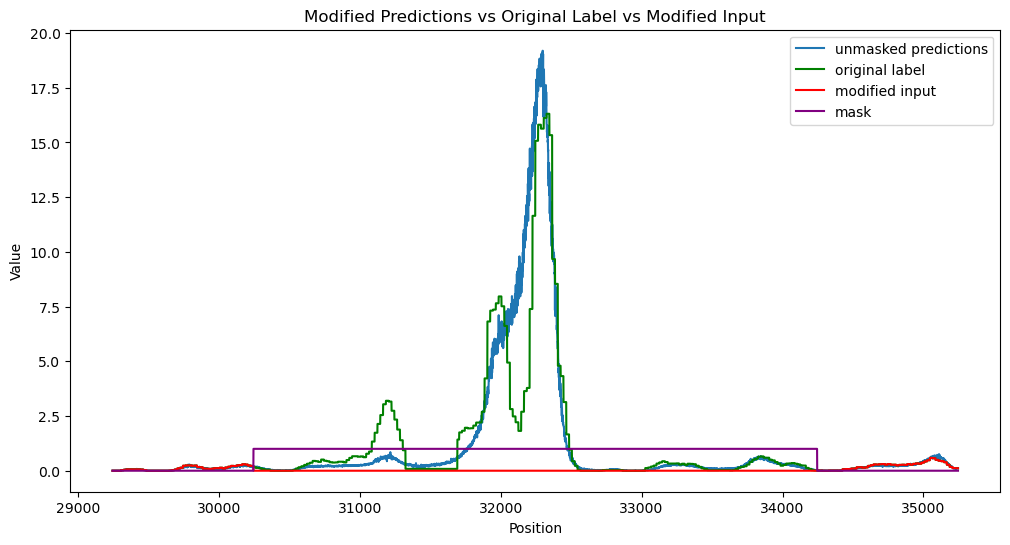

In [7]:
#now test on GM12878
evals_gm.dataset.expand_seqs(df.iloc[100][0], df.iloc[100][1], df.iloc[100][2])
tempidx = 1062 #this is the index for the seq, this dataset only one cell type!
out = evals_gm.mask(max_index-2000, max_index+2000,
                     tempidx, mask_accessibility=True)
start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()
plt.show()

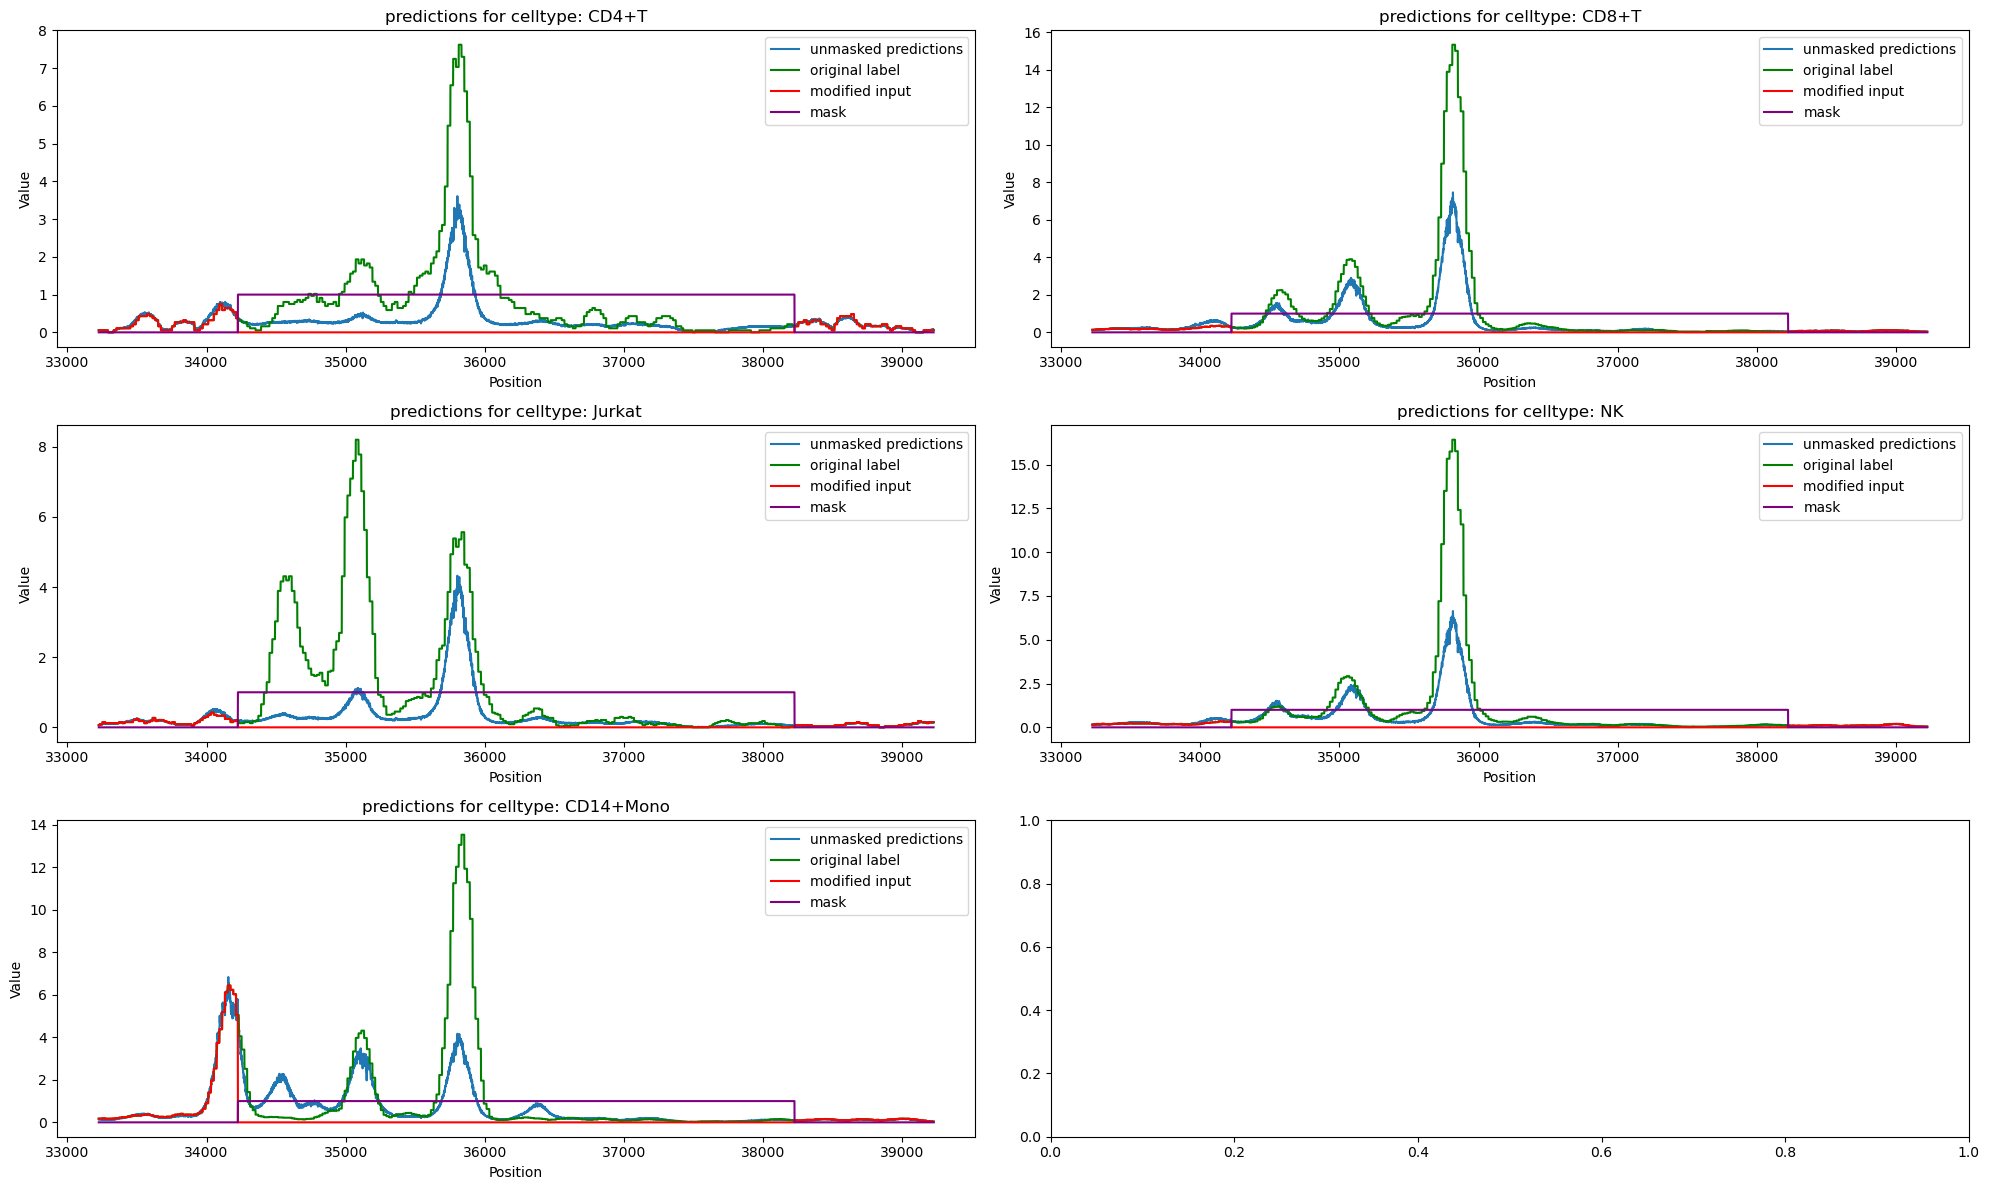

In [8]:
#now unseen peak and celltype
evals.dataset.expand_seqs(df.iloc[5][0], df.iloc[5][1], df.iloc[5][2])

celltype_names = ['CD4+T', 'CD8+T', 'Jurkat', 'NK', 'CD14+Mono']
max_index = 36225
#now loop through and make it a subplot
fig, axs = plt.subplots(3, 2, figsize=(20, 12))
axs = axs.flatten()
for i in range(5):
    tempidx = 1063 + len(evals.dataset.sequences) * i
    out = evals.mask(max_index-2000, max_index+2000,
                     tempidx, mask_accessibility=True)

    start = max_index - 3000
    end   = max_index + 3000
    x_vals = np.arange(start, end)

    y_vals           = out[1][0, start:end, 0].cpu().numpy()
    y_vals_original  = out[3][:, 0].cpu().numpy()[start:end]
    y_vals_input     = out[5][0, 0, start:end].cpu().numpy()
    mask             = out[-1][0, 1, start:end].cpu().numpy()

    ax = axs[i]
    ax.plot(x_vals, y_vals,          label='unmasked predictions')
    ax.plot(x_vals, y_vals_original, label='original label', color='green')
    ax.plot(x_vals, y_vals_input,    label='modified input', color='red')
    ax.plot(x_vals, mask,            label='mask',           color='purple')

    ax.set_xlabel('Position')
    ax.set_ylabel('Value')
    ax.set_title(f'predictions for celltype: {celltype_names[i]}')
    ax.legend()
    
fig.tight_layout()
plt.show()

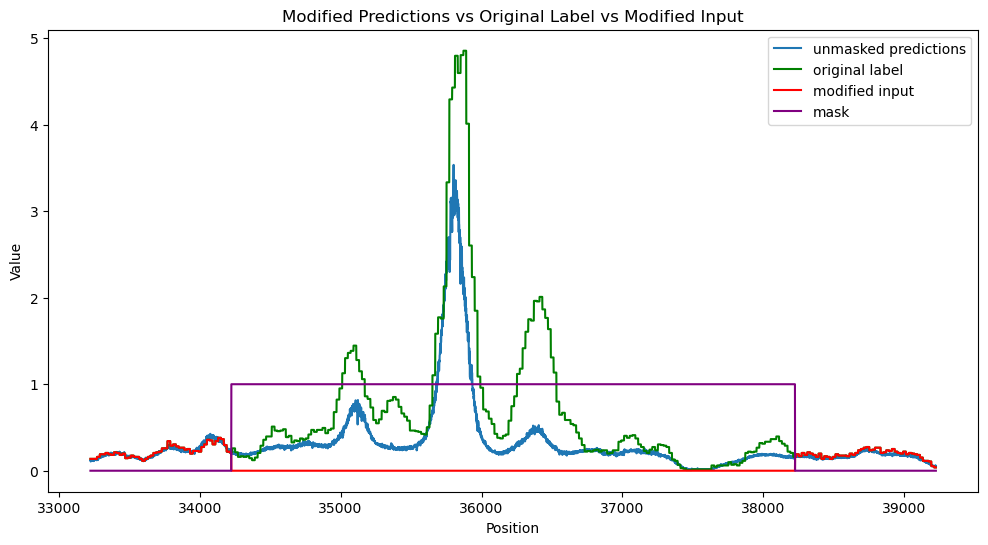

In [9]:
evals_gm.dataset.expand_seqs(df.iloc[5][0], df.iloc[5][1], df.iloc[5][2])
tempidx = 1063

out = evals_gm.mask(max_index-2000, max_index+2000,
                     tempidx, mask_accessibility=True)
start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()
plt.show()

# look for more examples, auotomate this process

In [ ]:
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

split = 'test'
device = '3'

enformer_seqs = '/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed'
df = pd.read_csv(enformer_seqs, sep='\t', header=None)
df = df[df[3] == split].reset_index(drop=True)

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-04-17/12-31-41-192495/checkpoints/last.ckpt' #for the generalizing model

#start with seeing how it generalizes to new regions
evals = Evals(ckpt_path, dataset=None, split=split, device=device, load_data=False)

#now load it in for GM12878
evals_gm = Evals(ckpt_path, dataset=None, split=split, device=device, load_data=False, data_idxs=[12])

ckpt_path_og = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'
evals_og = Evals(ckpt_path_og, dataset=None, split=split, device=device, load_data=False, sequences_bed_file=enformer_seqs)

evals_og.dataset.sequences[evals_og.dataset.sequences[0].isin(['chr4','chr14'])]

#now let's find some good examples

In [ ]:
#now given an example, we can plot it. Need idx_og and max_index from it
#can make this a loop where have idx_og list and max_index list
idx = evals.dataset.expand_seqs(df.iloc[idx_og][0], df.iloc[idx_og][1], df.iloc[idx_og][2])
idx_gm = evals_gm.dataset.expand_seqs(df.iloc[idx_og][0], df.iloc[idx_og][1], df.iloc[idx_og][2])

celltype_names = ['CD4+T', 'CD8+T', 'Jurkat', 'NK', 'CD14+Mono']
#now loop through and make it a subplot
fig, axs = plt.subplots(3, 2, figsize=(20, 12))
axs = axs.flatten()
for i in range(5):
    tempidx = idx + len(evals.dataset.sequences) * i
    out = evals.mask(max_index-2000, max_index+2000,
                     tempidx, mask_accessibility=True)

    start = max_index - 3000
    end   = max_index + 3000
    x_vals = np.arange(start, end)

    y_vals           = out[1][0, start:end, 0].cpu().numpy()
    y_vals_original  = out[3][:, 0].cpu().numpy()[start:end]
    y_vals_input     = out[5][0, 0, start:end].cpu().numpy()
    mask             = out[-1][0, 1, start:end].cpu().numpy()

    ax = axs[i]
    ax.plot(x_vals, y_vals,          label='unmasked predictions')
    ax.plot(x_vals, y_vals_original, label='original label', color='green')
    ax.plot(x_vals, y_vals_input,    label='modified input', color='red')
    ax.plot(x_vals, mask,            label='mask',           color='purple')

    ax.set_xlabel('Position')
    ax.set_ylabel('Value')
    ax.set_title(f'predictions for celltype: {celltype_names[i]}')
    ax.legend()
    
fig.tight_layout()
plt.show()

tempidx = idx_gm
out = evals_gm.mask(max_index-2000, max_index+2000,
                     tempidx, mask_accessibility=True)
start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

mask = out[-1][0,1, start:end].cpu().numpy()
plt.plot(x_vals, mask, label='mask', color='purple')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()
plt.show()